In [1]:
import importlib
import Battery_learner_3_0 as bl
import tensorflow as tf
import numpy as np
importlib.reload(bl) 
from tensorflow.keras import regularizers
# print(dir(bl))
# print(bl.DynamicProcessSolver)

In [2]:

class SingleCell(bl.DynamicProcessSolver):

    def _build_layers(self):
          
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation=None)  # 线性激活
        ])  
        self.update = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit)
        ])  
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        self.resnet= tf.keras.layers.Dense(self.num_outputs)
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.num_outputs, activation=None)  # 输出维度与输入一致
        ])

    def _process_step(self, x, states):
                 
        x = self.layer_norm1(x)
        x_flat = self.flatten(x)
        x = self.encoder(x_flat)
        states = self.update(x)  
        states = self.layer_norm2(states) 
        
        y = self.decoder(states)+ self.resnet(x_flat)
        
        return y, states # 返回张量 y    

class TwoLayerCell(bl.DynamicProcessSolver):

    def _build_layers(self):
           
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation=None)  # 线性激活
        ])  
        self.update = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit),
            tf.keras.layers.Dense(self.unit)
        ])  
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        self.resnet= tf.keras.layers.Dense(self.num_outputs)
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.num_outputs, activation=None)  # 输出维度与输入一致
        ])

    def _process_step(self, x, states):
                 
        x = self.layer_norm1(x)
        x_flat = self.flatten(x)
        x = self.encoder(x_flat)
        
        states = self.update(x)  
        states = self.layer_norm2(states) 
        
        y = self.decoder(states)+ self.resnet(x_flat)
        
        return y, states # 返回张量 y 
    
class GRUCell(bl.DynamicProcessSolver):

    def _build_layers(self):
        
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation=None)  # 线性激活
        ])  
        
        self.rnncell = tf.keras.layers.GRUCell(self.unit) 
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        self.update= tf.keras.layers.Dense(self.unit)
        
        self.resnet= tf.keras.layers.Dense(self.num_outputs)
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.num_outputs, activation=None)  # 输出维度与输入一致
        ])

    def _process_step(self, x, states):
                 
        x = self.layer_norm1(x)
        x_flat = self.flatten(x)
        x = self.encoder(x_flat)

        states, _ = self.rnncell(x, states=states)  
        states = states + self.update(x)
        states = self.layer_norm2(states)
        
        y = self.decoder(states)+ self.resnet(x_flat)       
        return y, states # 返回张量 y     
       
class RK4Cell(bl.DynamicProcessSolver):
    
    def _build_layers(self):
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.encoder1 = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation=None)  # 线性激活
        ])
        self.encoder2 = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit, activation=None)
        ])
        
        self.rnncell = tf.keras.layers.GRUCell(self.unit)
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        
        # 增强 func 网络 + 输出约束
        self.func = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation='relu') 
        ])
        self.layer_norm3 = tf.keras.layers.LayerNormalization()
        
        self.resnet= tf.keras.layers.Dense(self.num_outputs)
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.num_outputs, activation=None)  # 输出维度与输入一致
        ])
        

    def _process_step(self, x, h_prev):
        
        x = self.layer_norm1(x)
        x_flat = self.flatten(x)
          
        h_prev, _ = self.rnncell(self.encoder1(x_flat), states=h_prev) 
        h_prev = self.layer_norm2(h_prev)

        # RK4计算
        x = self.encoder2(x)
        dt = 1.0
        concat_input = lambda a, b: tf.concat([a, b], axis=-1)
        
        k1 = dt * self.func(concat_input(x[:, -1, :], h_prev))
        k2 = dt * self.func(concat_input((x[:, -1, :] + x[:, -2, :])/2, h_prev + 0.5*k1))
        k3 = dt * self.func(concat_input((x[:, -1, :] + x[:, -2, :])/2, h_prev + 0.5*k2))
        k4 = dt * self.func(concat_input(x[:, -2, :], h_prev + k3))

        h_next = h_prev + (k1 + 2*k2 + 2*k3 + k4)/6.0
        h_next = self.layer_norm3(h_next)
              
        y = self.decoder(h_next)+ self.resnet(self.flatten(x))
        
        return y, h_next
    
class KoopmanCell(bl.DynamicProcessSolver):

    def _build_layers(self):
               
        self.layer_norm1 = tf.keras.layers.LayerNormalization()     
        self.flatten = tf.keras.layers.Flatten()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.unit, activation=None)  # 线性激活保证 Koopman 算子有效性
        ])
        # 动态参数生成网络
        self.rnncell = tf.keras.layers.GRUCell(self.unit) 
        
        self.context_net = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit * self.unit)
        ])
        
        self.layer_norm2 = tf.keras.layers.LayerNormalization()
        
        self.resnet= tf.keras.layers.Dense(self.num_outputs)
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(self.unit*2, activation='relu'),
            tf.keras.layers.Dense(self.num_outputs, activation=None)  # 输出维度与输入一致
        ])
        

    def _process_step(self, x, states):
            
        x = self.layer_norm1(x)
        x_flat = self.flatten(x)
        x = self.encoder(x_flat)

        states, _ = self.rnncell(x, states=states) 
        states = self.layer_norm2(states)
        
        K_t = tf.reshape(self.context_net(states), [-1, self.unit, self.unit])
        
        x_new = tf.einsum('bij,bj->bi', K_t, x)  # 使用动态矩阵演化   
        
        y = self.decoder(x_new)+ self.resnet(x_flat)
        
        return y, states   

In [3]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

columns = ['rate','voltage','soc']
columns_all = ['rate','voltage','soc',
            'negative average soc',
            'negative surface soc',
            'positive average soc',
            'positive surface soc',
            'negative overpotential',
            'positive overpotential',
            'negative potential',
            'positive potential',
            'electrolyte potential']

file_list = ["spme_cccv_data0.05",
        "spme_cccv_data0.1",
        "spme_cccv_data0.2",
        "spme_cccv_data0.4",
        "spme_cccv_data0.8",
        "spme_cccv_data1.6",
        "spme_dc_data0.3",
        "spme_dc_data0.5",
        "spme_dc_data0.7",
        "spme_dc_data0.9",]
file_list_test = [
        "spme_cccv_data0.3",
        "spme_cccv_data1",
        "spme_dc_data0.4",
        "spme_dc_data0.6",
           ]

dataset = bl.preprocess(
                filelist = file_list,
                columns = columns_all,
                lookback = 1,                
                num_steps = 30,
                max_samples = 6000
)

dataset_train, dataset_test = bl.data_shuffle_split(dataset, test_size = 0.1)
print("训练集：",dataset_train.shape)
print("测试集：",dataset_test.shape)

# adapt_data = tf.reshape(dataset_train,(-1,dataset_train.shape[-1]))
# mean = np.mean(adapt_data,axis=0)
# var = np.var(adapt_data,axis=0)
# print("样本均值及方差张量尺寸：",mean.shape, var.shape)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
(59884, 30, 12)
训练集： (53895, 30, 12)
测试集： (5989, 30, 12)


RK4Cell_unit4_r0_int5-30
(2, 30, 12)
11
(2, 26)
Model: "rk4_cell"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization (LayerN  multiple                 28        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 sequential (Sequential)     (2, 4)                    380       
                                                                 
 sequential_1 (Sequential)   (2, 3, 4)                 60        
                                                                 
 gru_cell (GRUCell)          multiple                  120       
                                                                 
 layer_normalization_1 (Laye  multiple                 8         
 rNormaliz

Epoch 10/200
190/190 [==============================] - 92s 482ms/step - loss: 0.0365 - output_1_loss: 0.0567 - output_2_loss: 0.0797 - output_3_loss: 0.0461 - output_4_loss: 0.0495 - output_5_loss: 0.0610 - output_6_loss: 0.0533 - output_7_loss: 0.0014 - output_8_loss: 2.8956e-04 - output_9_loss: 0.0021 - output_10_loss: 0.0467 - output_11_loss: 0.0047 - val_loss: 0.0359 - val_output_1_loss: 0.0553 - val_output_2_loss: 0.0789 - val_output_3_loss: 0.0454 - val_output_4_loss: 0.0488 - val_output_5_loss: 0.0604 - val_output_6_loss: 0.0525 - val_output_7_loss: 0.0013 - val_output_8_loss: 2.7692e-04 - val_output_9_loss: 0.0020 - val_output_10_loss: 0.0453 - val_output_11_loss: 0.0045 - lr: 0.0010
Epoch 11/200
190/190 [==============================] - 92s 486ms/step - loss: 0.0360 - output_1_loss: 0.0556 - output_2_loss: 0.0793 - output_3_loss: 0.0455 - output_4_loss: 0.0489 - output_5_loss: 0.0607 - output_6_loss: 0.0526 - output_7_loss: 0.0012 - output_8_loss: 2.7175e-04 - output_9_loss:

Epoch 22/200
190/190 [==============================] - 91s 478ms/step - loss: 0.0015 - output_1_loss: 0.0024 - output_2_loss: 8.4402e-04 - output_3_loss: 0.0012 - output_4_loss: 0.0012 - output_5_loss: 0.0018 - output_6_loss: 8.2405e-04 - output_7_loss: 9.3640e-05 - output_8_loss: 7.4355e-05 - output_9_loss: 0.0015 - output_10_loss: 0.0026 - output_11_loss: 0.0036 - val_loss: 0.0015 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0011 - val_output_3_loss: 0.0012 - val_output_4_loss: 0.0012 - val_output_5_loss: 0.0020 - val_output_6_loss: 0.0012 - val_output_7_loss: 9.4227e-05 - val_output_8_loss: 6.7028e-05 - val_output_9_loss: 0.0015 - val_output_10_loss: 0.0025 - val_output_11_loss: 0.0036 - lr: 0.0010
Epoch 23/200
190/190 [==============================] - 94s 496ms/step - loss: 0.0014 - output_1_loss: 0.0023 - output_2_loss: 7.8047e-04 - output_3_loss: 0.0011 - output_4_loss: 0.0010 - output_5_loss: 0.0016 - output_6_loss: 7.5191e-04 - output_7_loss: 9.1305e-05 - output_8_loss:

Epoch 33/200
190/190 [==============================] - 91s 481ms/step - loss: 8.1941e-04 - output_1_loss: 0.0020 - output_2_loss: 5.0829e-04 - output_3_loss: 6.6990e-04 - output_4_loss: 3.7815e-04 - output_5_loss: 6.1177e-04 - output_6_loss: 4.4509e-04 - output_7_loss: 6.9771e-05 - output_8_loss: 5.0717e-05 - output_9_loss: 4.7132e-04 - output_10_loss: 0.0017 - output_11_loss: 0.0022 - val_loss: 7.8204e-04 - val_output_1_loss: 0.0018 - val_output_2_loss: 5.1893e-04 - val_output_3_loss: 6.3307e-04 - val_output_4_loss: 3.5942e-04 - val_output_5_loss: 6.2057e-04 - val_output_6_loss: 4.5082e-04 - val_output_7_loss: 6.7542e-05 - val_output_8_loss: 4.8723e-05 - val_output_9_loss: 4.4944e-04 - val_output_10_loss: 0.0016 - val_output_11_loss: 0.0021 - lr: 0.0010
Epoch 34/200
190/190 [==============================] - 92s 484ms/step - loss: 7.9007e-04 - output_1_loss: 0.0019 - output_2_loss: 4.9228e-04 - output_3_loss: 6.4684e-04 - output_4_loss: 3.6730e-04 - output_5_loss: 5.8517e-04 - output

Epoch 44/200
190/190 [==============================] - 93s 490ms/step - loss: 6.3378e-04 - output_1_loss: 0.0016 - output_2_loss: 4.2998e-04 - output_3_loss: 4.9976e-04 - output_4_loss: 3.0083e-04 - output_5_loss: 4.4172e-04 - output_6_loss: 3.6332e-04 - output_7_loss: 6.2500e-05 - output_8_loss: 4.2172e-05 - output_9_loss: 1.8275e-04 - output_10_loss: 0.0013 - output_11_loss: 0.0017 - val_loss: 5.9165e-04 - val_output_1_loss: 0.0015 - val_output_2_loss: 3.9801e-04 - val_output_3_loss: 4.4685e-04 - val_output_4_loss: 2.8167e-04 - val_output_5_loss: 4.3845e-04 - val_output_6_loss: 3.2871e-04 - val_output_7_loss: 5.7989e-05 - val_output_8_loss: 4.0686e-05 - val_output_9_loss: 1.7254e-04 - val_output_10_loss: 0.0012 - val_output_11_loss: 0.0016 - lr: 0.0010
Epoch 45/200
190/190 [==============================] - 91s 479ms/step - loss: 6.2376e-04 - output_1_loss: 0.0015 - output_2_loss: 4.3009e-04 - output_3_loss: 4.9047e-04 - output_4_loss: 2.9716e-04 - output_5_loss: 4.3365e-04 - output

Epoch 55/200
190/190 [==============================] - 96s 503ms/step - loss: 5.2288e-04 - output_1_loss: 0.0013 - output_2_loss: 3.8820e-04 - output_3_loss: 4.1018e-04 - output_4_loss: 2.4687e-04 - output_5_loss: 3.5329e-04 - output_6_loss: 3.0634e-04 - output_7_loss: 6.4138e-05 - output_8_loss: 3.3616e-05 - output_9_loss: 1.0035e-04 - output_10_loss: 0.0011 - output_11_loss: 0.0015 - val_loss: 4.9892e-04 - val_output_1_loss: 0.0012 - val_output_2_loss: 3.6599e-04 - val_output_3_loss: 3.9292e-04 - val_output_4_loss: 2.2957e-04 - val_output_5_loss: 3.3708e-04 - val_output_6_loss: 2.9930e-04 - val_output_7_loss: 6.6970e-05 - val_output_8_loss: 3.3004e-05 - val_output_9_loss: 9.8440e-05 - val_output_10_loss: 0.0010 - val_output_11_loss: 0.0014 - lr: 5.0000e-04
Epoch 56/200
190/190 [==============================] - 93s 489ms/step - loss: 5.0983e-04 - output_1_loss: 0.0012 - output_2_loss: 3.7039e-04 - output_3_loss: 4.0046e-04 - output_4_loss: 2.3813e-04 - output_5_loss: 3.4231e-04 - ou

Epoch 66/200
190/190 [==============================] - 95s 501ms/step - loss: 3.8849e-04 - output_1_loss: 9.1676e-04 - output_2_loss: 3.3296e-04 - output_3_loss: 3.5645e-04 - output_4_loss: 2.2583e-04 - output_5_loss: 2.5843e-04 - output_6_loss: 2.4333e-04 - output_7_loss: 7.9311e-05 - output_8_loss: 2.8069e-05 - output_9_loss: 8.4641e-05 - output_10_loss: 7.0750e-04 - output_11_loss: 0.0010 - val_loss: 3.5868e-04 - val_output_1_loss: 8.2005e-04 - val_output_2_loss: 3.2232e-04 - val_output_3_loss: 3.4074e-04 - val_output_4_loss: 2.1424e-04 - val_output_5_loss: 2.5114e-04 - val_output_6_loss: 2.3576e-04 - val_output_7_loss: 7.9291e-05 - val_output_8_loss: 2.7047e-05 - val_output_9_loss: 8.5151e-05 - val_output_10_loss: 6.2550e-04 - val_output_11_loss: 9.4427e-04 - lr: 5.0000e-04
Epoch 67/200
190/190 [==============================] - 94s 495ms/step - loss: 3.6255e-04 - output_1_loss: 8.2572e-04 - output_2_loss: 3.3018e-04 - output_3_loss: 3.6085e-04 - output_4_loss: 2.2881e-04 - output

190/190 [==============================] - 91s 478ms/step - loss: 1.9078e-04 - output_1_loss: 4.0956e-04 - output_2_loss: 1.8078e-04 - output_3_loss: 1.6998e-04 - output_4_loss: 1.4212e-04 - output_5_loss: 2.6462e-04 - output_6_loss: 1.8775e-04 - output_7_loss: 6.6853e-05 - output_8_loss: 2.0795e-05 - output_9_loss: 8.3634e-05 - output_10_loss: 2.9732e-04 - output_11_loss: 2.7516e-04 - val_loss: 1.7512e-04 - val_output_1_loss: 3.8248e-04 - val_output_2_loss: 1.7041e-04 - val_output_3_loss: 1.4588e-04 - val_output_4_loss: 1.1999e-04 - val_output_5_loss: 2.4523e-04 - val_output_6_loss: 1.7132e-04 - val_output_7_loss: 5.5973e-05 - val_output_8_loss: 2.0473e-05 - val_output_9_loss: 8.0804e-05 - val_output_10_loss: 2.7902e-04 - val_output_11_loss: 2.5476e-04 - lr: 5.0000e-04
Epoch 77/200
190/190 [==============================] - 92s 484ms/step - loss: 1.8504e-04 - output_1_loss: 3.9366e-04 - output_2_loss: 1.7902e-04 - output_3_loss: 1.6241e-04 - output_4_loss: 1.3983e-04 - output_5_loss: 

190/190 [==============================] - 94s 494ms/step - loss: 1.3129e-04 - output_1_loss: 2.5603e-04 - output_2_loss: 1.3512e-04 - output_3_loss: 1.1315e-04 - output_4_loss: 9.5394e-05 - output_5_loss: 1.7655e-04 - output_6_loss: 1.5664e-04 - output_7_loss: 4.1720e-05 - output_8_loss: 1.9357e-05 - output_9_loss: 5.5304e-05 - output_10_loss: 2.0227e-04 - output_11_loss: 1.9271e-04 - val_loss: 1.3476e-04 - val_output_1_loss: 2.4326e-04 - val_output_2_loss: 1.5171e-04 - val_output_3_loss: 1.1945e-04 - val_output_4_loss: 1.0489e-04 - val_output_5_loss: 1.9682e-04 - val_output_6_loss: 1.6391e-04 - val_output_7_loss: 3.7516e-05 - val_output_8_loss: 1.9206e-05 - val_output_9_loss: 5.3698e-05 - val_output_10_loss: 1.9860e-04 - val_output_11_loss: 1.9328e-04 - lr: 5.0000e-04
Epoch 87/200
190/190 [==============================] - 93s 488ms/step - loss: 1.2428e-04 - output_1_loss: 2.4155e-04 - output_2_loss: 1.2609e-04 - output_3_loss: 1.0776e-04 - output_4_loss: 8.8078e-05 - output_5_loss: 

Epoch 96/200
190/190 [==============================] - 91s 481ms/step - loss: 1.0650e-04 - output_1_loss: 2.0623e-04 - output_2_loss: 1.0575e-04 - output_3_loss: 9.5040e-05 - output_4_loss: 6.9051e-05 - output_5_loss: 1.3336e-04 - output_6_loss: 1.3279e-04 - output_7_loss: 3.8879e-05 - output_8_loss: 1.6519e-05 - output_9_loss: 3.8744e-05 - output_10_loss: 1.7201e-04 - output_11_loss: 1.6313e-04 - val_loss: 1.0076e-04 - val_output_1_loss: 2.0008e-04 - val_output_2_loss: 1.0121e-04 - val_output_3_loss: 8.6186e-05 - val_output_4_loss: 5.4851e-05 - val_output_5_loss: 1.2478e-04 - val_output_6_loss: 1.2595e-04 - val_output_7_loss: 3.5013e-05 - val_output_8_loss: 1.5904e-05 - val_output_9_loss: 3.7885e-05 - val_output_10_loss: 1.6560e-04 - val_output_11_loss: 1.6090e-04 - lr: 2.5000e-04
Epoch 97/200
190/190 [==============================] - 93s 490ms/step - loss: 1.0286e-04 - output_1_loss: 1.9978e-04 - output_2_loss: 1.0043e-04 - output_3_loss: 9.1045e-05 - output_4_loss: 6.4385e-05 - ou

Epoch 106/200
190/190 [==============================] - 94s 493ms/step - loss: 9.3671e-05 - output_1_loss: 1.8387e-04 - output_2_loss: 8.8913e-05 - output_3_loss: 8.3400e-05 - output_4_loss: 5.5951e-05 - output_5_loss: 1.1317e-04 - output_6_loss: 1.1598e-04 - output_7_loss: 3.6879e-05 - output_8_loss: 1.4731e-05 - output_9_loss: 3.1100e-05 - output_10_loss: 1.5656e-04 - output_11_loss: 1.4982e-04 - val_loss: 9.1058e-05 - val_output_1_loss: 1.8391e-04 - val_output_2_loss: 8.4704e-05 - val_output_3_loss: 7.8235e-05 - val_output_4_loss: 5.1930e-05 - val_output_5_loss: 1.0857e-04 - val_output_6_loss: 1.1378e-04 - val_output_7_loss: 3.3347e-05 - val_output_8_loss: 1.4236e-05 - val_output_9_loss: 3.0502e-05 - val_output_10_loss: 1.5836e-04 - val_output_11_loss: 1.4407e-04 - lr: 1.2500e-04
Epoch 107/200
190/190 [==============================] - 92s 482ms/step - loss: 9.3802e-05 - output_1_loss: 1.8434e-04 - output_2_loss: 8.9637e-05 - output_3_loss: 8.4100e-05 - output_4_loss: 5.6536e-05 - 

Epoch 116/200
190/190 [==============================] - 95s 502ms/step - loss: 8.8359e-05 - output_1_loss: 1.7557e-04 - output_2_loss: 8.2316e-05 - output_3_loss: 7.9099e-05 - output_4_loss: 5.1701e-05 - output_5_loss: 1.0406e-04 - output_6_loss: 1.0826e-04 - output_7_loss: 3.5592e-05 - output_8_loss: 1.3660e-05 - output_9_loss: 2.7251e-05 - output_10_loss: 1.5182e-04 - output_11_loss: 1.4263e-04 - val_loss: 8.6441e-05 - val_output_1_loss: 1.7602e-04 - val_output_2_loss: 8.0623e-05 - val_output_3_loss: 7.3590e-05 - val_output_4_loss: 4.6753e-05 - val_output_5_loss: 1.0198e-04 - val_output_6_loss: 1.0767e-04 - val_output_7_loss: 3.2321e-05 - val_output_8_loss: 1.3096e-05 - val_output_9_loss: 2.6792e-05 - val_output_10_loss: 1.5231e-04 - val_output_11_loss: 1.3970e-04 - lr: 6.2500e-05
Epoch 117/200
190/190 [==============================] - 94s 497ms/step - loss: 8.7936e-05 - output_1_loss: 1.7504e-04 - output_2_loss: 8.1884e-05 - output_3_loss: 7.8738e-05 - output_4_loss: 5.1260e-05 - 

Epoch 126/200
190/190 [==============================] - 92s 486ms/step - loss: 8.5167e-05 - output_1_loss: 1.7070e-04 - output_2_loss: 7.8815e-05 - output_3_loss: 7.6506e-05 - output_4_loss: 4.9151e-05 - output_5_loss: 9.8859e-05 - output_6_loss: 1.0363e-04 - output_7_loss: 3.4490e-05 - output_8_loss: 1.2991e-05 - output_9_loss: 2.5250e-05 - output_10_loss: 1.4862e-04 - output_11_loss: 1.3782e-04 - val_loss: 8.4002e-05 - val_output_1_loss: 1.7255e-04 - val_output_2_loss: 7.7962e-05 - val_output_3_loss: 7.3496e-05 - val_output_4_loss: 4.5906e-05 - val_output_5_loss: 9.8784e-05 - val_output_6_loss: 9.9378e-05 - val_output_7_loss: 3.1804e-05 - val_output_8_loss: 1.2564e-05 - val_output_9_loss: 2.4852e-05 - val_output_10_loss: 1.5001e-04 - val_output_11_loss: 1.3672e-04 - lr: 3.1250e-05
Epoch 127/200
190/190 [==============================] - 91s 478ms/step - loss: 8.5054e-05 - output_1_loss: 1.7098e-04 - output_2_loss: 7.8504e-05 - output_3_loss: 7.5910e-05 - output_4_loss: 4.8687e-05 - 

Epoch 136/200
190/190 [==============================] - 93s 490ms/step - loss: 8.3404e-05 - output_1_loss: 1.6828e-04 - output_2_loss: 7.6553e-05 - output_3_loss: 7.4489e-05 - output_4_loss: 4.7567e-05 - output_5_loss: 9.6170e-05 - output_6_loss: 1.0056e-04 - output_7_loss: 3.4050e-05 - output_8_loss: 1.2664e-05 - output_9_loss: 2.4093e-05 - output_10_loss: 1.4695e-04 - output_11_loss: 1.3607e-04 - val_loss: 8.2250e-05 - val_output_1_loss: 1.6971e-04 - val_output_2_loss: 7.6073e-05 - val_output_3_loss: 7.1624e-05 - val_output_4_loss: 4.4409e-05 - val_output_5_loss: 9.4548e-05 - val_output_6_loss: 9.8420e-05 - val_output_7_loss: 3.1026e-05 - val_output_8_loss: 1.2176e-05 - val_output_9_loss: 2.3826e-05 - val_output_10_loss: 1.4836e-04 - val_output_11_loss: 1.3458e-04 - lr: 1.5625e-05
Epoch 137/200
190/190 [==============================] - 94s 493ms/step - loss: 8.3392e-05 - output_1_loss: 1.6793e-04 - output_2_loss: 7.6786e-05 - output_3_loss: 7.4923e-05 - output_4_loss: 4.7712e-05 - 

Epoch 146/200
190/190 [==============================] - 91s 476ms/step - loss: 8.2430e-05 - output_1_loss: 1.6697e-04 - output_2_loss: 7.5607e-05 - output_3_loss: 7.3671e-05 - output_4_loss: 4.6623e-05 - output_5_loss: 9.4294e-05 - output_6_loss: 9.8824e-05 - output_7_loss: 3.3726e-05 - output_8_loss: 1.2447e-05 - output_9_loss: 2.3376e-05 - output_10_loss: 1.4618e-04 - output_11_loss: 1.3502e-04 - val_loss: 8.1409e-05 - val_output_1_loss: 1.6881e-04 - val_output_2_loss: 7.6006e-05 - val_output_3_loss: 7.0348e-05 - val_output_4_loss: 4.3043e-05 - val_output_5_loss: 9.3296e-05 - val_output_6_loss: 9.7118e-05 - val_output_7_loss: 3.0779e-05 - val_output_8_loss: 1.2002e-05 - val_output_9_loss: 2.3147e-05 - val_output_10_loss: 1.4806e-04 - val_output_11_loss: 1.3290e-04 - lr: 1.0000e-05
Epoch 147/200
190/190 [==============================] - 91s 478ms/step - loss: 8.2306e-05 - output_1_loss: 1.6655e-04 - output_2_loss: 7.5517e-05 - output_3_loss: 7.3673e-05 - output_4_loss: 4.6700e-05 - 

190/190 [==============================] - 95s 498ms/step - loss: 8.1486e-05 - output_1_loss: 1.6539e-04 - output_2_loss: 7.4720e-05 - output_3_loss: 7.2933e-05 - output_4_loss: 4.6014e-05 - output_5_loss: 9.2542e-05 - output_6_loss: 9.7507e-05 - output_7_loss: 3.3407e-05 - output_8_loss: 1.2276e-05 - output_9_loss: 2.2789e-05 - output_10_loss: 1.4511e-04 - output_11_loss: 1.3366e-04 - val_loss: 8.0303e-05 - val_output_1_loss: 1.6760e-04 - val_output_2_loss: 7.3085e-05 - val_output_3_loss: 6.9289e-05 - val_output_4_loss: 4.3228e-05 - val_output_5_loss: 9.1138e-05 - val_output_6_loss: 9.5237e-05 - val_output_7_loss: 3.0487e-05 - val_output_8_loss: 1.1844e-05 - val_output_9_loss: 2.2568e-05 - val_output_10_loss: 1.4731e-04 - val_output_11_loss: 1.3154e-04 - lr: 1.0000e-05
Epoch 157/200
190/190 [==============================] - 92s 485ms/step - loss: 8.1487e-05 - output_1_loss: 1.6545e-04 - output_2_loss: 7.4464e-05 - output_3_loss: 7.3074e-05 - output_4_loss: 4.6264e-05 - output_5_loss:

190/190 [==============================] - 90s 475ms/step - loss: 8.0716e-05 - output_1_loss: 1.6444e-04 - output_2_loss: 7.3767e-05 - output_3_loss: 7.2183e-05 - output_4_loss: 4.5498e-05 - output_5_loss: 9.1106e-05 - output_6_loss: 9.6125e-05 - output_7_loss: 3.3123e-05 - output_8_loss: 1.2114e-05 - output_9_loss: 2.2265e-05 - output_10_loss: 1.4460e-04 - output_11_loss: 1.3265e-04 - val_loss: 7.9648e-05 - val_output_1_loss: 1.6642e-04 - val_output_2_loss: 7.2958e-05 - val_output_3_loss: 6.8912e-05 - val_output_4_loss: 4.2174e-05 - val_output_5_loss: 9.0183e-05 - val_output_6_loss: 9.2957e-05 - val_output_7_loss: 3.0303e-05 - val_output_8_loss: 1.1678e-05 - val_output_9_loss: 2.2104e-05 - val_output_10_loss: 1.4650e-04 - val_output_11_loss: 1.3194e-04 - lr: 1.0000e-05
Epoch 167/200
190/190 [==============================] - 93s 491ms/step - loss: 8.0663e-05 - output_1_loss: 1.6449e-04 - output_2_loss: 7.3677e-05 - output_3_loss: 7.1993e-05 - output_4_loss: 4.5295e-05 - output_5_loss:

190/190 [==============================] - 94s 494ms/step - loss: 7.9924e-05 - output_1_loss: 1.6338e-04 - output_2_loss: 7.2848e-05 - output_3_loss: 7.1525e-05 - output_4_loss: 4.4972e-05 - output_5_loss: 8.9604e-05 - output_6_loss: 9.4831e-05 - output_7_loss: 3.2830e-05 - output_8_loss: 1.1960e-05 - output_9_loss: 2.1731e-05 - output_10_loss: 1.4385e-04 - output_11_loss: 1.3163e-04 - val_loss: 7.9063e-05 - val_output_1_loss: 1.6563e-04 - val_output_2_loss: 7.2440e-05 - val_output_3_loss: 6.8983e-05 - val_output_4_loss: 4.2280e-05 - val_output_5_loss: 8.7957e-05 - val_output_6_loss: 9.2123e-05 - val_output_7_loss: 2.9892e-05 - val_output_8_loss: 1.1534e-05 - val_output_9_loss: 2.1545e-05 - val_output_10_loss: 1.4618e-04 - val_output_11_loss: 1.3113e-04 - lr: 1.0000e-05
Epoch 177/200
190/190 [==============================] - 91s 479ms/step - loss: 7.9867e-05 - output_1_loss: 1.6324e-04 - output_2_loss: 7.2797e-05 - output_3_loss: 7.1492e-05 - output_4_loss: 4.4770e-05 - output_5_loss:

190/190 [==============================] - 92s 483ms/step - loss: 7.9197e-05 - output_1_loss: 1.6221e-04 - output_2_loss: 7.2179e-05 - output_3_loss: 7.0916e-05 - output_4_loss: 4.4175e-05 - output_5_loss: 8.8328e-05 - output_6_loss: 9.3127e-05 - output_7_loss: 3.2626e-05 - output_8_loss: 1.1810e-05 - output_9_loss: 2.1232e-05 - output_10_loss: 1.4320e-04 - output_11_loss: 1.3136e-04 - val_loss: 7.8240e-05 - val_output_1_loss: 1.6488e-04 - val_output_2_loss: 7.1739e-05 - val_output_3_loss: 6.7364e-05 - val_output_4_loss: 4.1180e-05 - val_output_5_loss: 8.6307e-05 - val_output_6_loss: 9.2097e-05 - val_output_7_loss: 2.9690e-05 - val_output_8_loss: 1.1333e-05 - val_output_9_loss: 2.0930e-05 - val_output_10_loss: 1.4597e-04 - val_output_11_loss: 1.2915e-04 - lr: 1.0000e-05
Epoch 187/200
190/190 [==============================] - 94s 494ms/step - loss: 7.9142e-05 - output_1_loss: 1.6221e-04 - output_2_loss: 7.2007e-05 - output_3_loss: 7.0864e-05 - output_4_loss: 4.4437e-05 - output_5_loss:

190/190 [==============================] - 91s 478ms/step - loss: 7.8451e-05 - output_1_loss: 1.6130e-04 - output_2_loss: 7.1395e-05 - output_3_loss: 7.0203e-05 - output_4_loss: 4.3821e-05 - output_5_loss: 8.6689e-05 - output_6_loss: 9.2171e-05 - output_7_loss: 3.2334e-05 - output_8_loss: 1.1664e-05 - output_9_loss: 2.0700e-05 - output_10_loss: 1.4281e-04 - output_11_loss: 1.2988e-04 - val_loss: 7.7464e-05 - val_output_1_loss: 1.6428e-04 - val_output_2_loss: 7.0245e-05 - val_output_3_loss: 6.6793e-05 - val_output_4_loss: 4.0585e-05 - val_output_5_loss: 8.5184e-05 - val_output_6_loss: 8.9892e-05 - val_output_7_loss: 2.9438e-05 - val_output_8_loss: 1.1265e-05 - val_output_9_loss: 2.0552e-05 - val_output_10_loss: 1.4527e-04 - val_output_11_loss: 1.2860e-04 - lr: 1.0000e-05
Epoch 197/200
190/190 [==============================] - 90s 474ms/step - loss: 7.8368e-05 - output_1_loss: 1.6111e-04 - output_2_loss: 7.1262e-05 - output_3_loss: 7.0148e-05 - output_4_loss: 4.3841e-05 - output_5_loss:

190/190 [==============================] - 92s 483ms/step - loss: 0.0395 - output_1_loss: 0.0508 - output_2_loss: 0.0793 - output_3_loss: 0.0552 - output_4_loss: 0.0564 - output_5_loss: 0.0611 - output_6_loss: 0.0590 - output_7_loss: 0.0014 - output_8_loss: 0.0046 - output_9_loss: 0.0098 - output_10_loss: 0.0479 - output_11_loss: 0.0087 - val_loss: 0.0383 - val_output_1_loss: 0.0487 - val_output_2_loss: 0.0784 - val_output_3_loss: 0.0544 - val_output_4_loss: 0.0558 - val_output_5_loss: 0.0604 - val_output_6_loss: 0.0579 - val_output_7_loss: 0.0012 - val_output_8_loss: 0.0036 - val_output_9_loss: 0.0076 - val_output_10_loss: 0.0460 - val_output_11_loss: 0.0070 - lr: 0.0010
Epoch 5/200
190/190 [==============================] - 92s 487ms/step - loss: 0.0382 - output_1_loss: 0.0487 - output_2_loss: 0.0787 - output_3_loss: 0.0545 - output_4_loss: 0.0558 - output_5_loss: 0.0609 - output_6_loss: 0.0581 - output_7_loss: 9.8413e-04 - output_8_loss: 0.0034 - output_9_loss: 0.0062 - output_10_lo

Epoch 16/200
190/190 [==============================] - 91s 480ms/step - loss: 0.0016 - output_1_loss: 0.0033 - output_2_loss: 0.0017 - output_3_loss: 8.2689e-04 - output_4_loss: 0.0014 - output_5_loss: 9.6720e-04 - output_6_loss: 0.0016 - output_7_loss: 2.4576e-04 - output_8_loss: 5.5342e-04 - output_9_loss: 0.0012 - output_10_loss: 0.0025 - output_11_loss: 0.0029 - val_loss: 0.0014 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0014 - val_output_3_loss: 7.1285e-04 - val_output_4_loss: 0.0013 - val_output_5_loss: 7.8928e-04 - val_output_6_loss: 0.0014 - val_output_7_loss: 2.4013e-04 - val_output_8_loss: 4.6848e-04 - val_output_9_loss: 0.0011 - val_output_10_loss: 0.0022 - val_output_11_loss: 0.0027 - lr: 0.0010
Epoch 17/200
190/190 [==============================] - 91s 481ms/step - loss: 0.0014 - output_1_loss: 0.0031 - output_2_loss: 0.0015 - output_3_loss: 7.5583e-04 - output_4_loss: 0.0012 - output_5_loss: 8.3170e-04 - output_6_loss: 0.0015 - output_7_loss: 2.2443e-04 - output

Epoch 27/200
190/190 [==============================] - 92s 485ms/step - loss: 9.1822e-04 - output_1_loss: 0.0021 - output_2_loss: 6.3478e-04 - output_3_loss: 4.9092e-04 - output_4_loss: 4.8048e-04 - output_5_loss: 4.0119e-04 - output_6_loss: 7.2374e-04 - output_7_loss: 1.5696e-04 - output_8_loss: 2.8277e-04 - output_9_loss: 8.3264e-04 - output_10_loss: 0.0018 - output_11_loss: 0.0022 - val_loss: 9.1780e-04 - val_output_1_loss: 0.0020 - val_output_2_loss: 7.0545e-04 - val_output_3_loss: 5.2940e-04 - val_output_4_loss: 5.3955e-04 - val_output_5_loss: 4.7997e-04 - val_output_6_loss: 7.3227e-04 - val_output_7_loss: 1.5921e-04 - val_output_8_loss: 2.7201e-04 - val_output_9_loss: 7.9785e-04 - val_output_10_loss: 0.0018 - val_output_11_loss: 0.0021 - lr: 0.0010
Epoch 28/200
190/190 [==============================] - 90s 476ms/step - loss: 8.9721e-04 - output_1_loss: 0.0020 - output_2_loss: 6.1800e-04 - output_3_loss: 4.9161e-04 - output_4_loss: 4.6777e-04 - output_5_loss: 3.9566e-04 - output

Epoch 38/200
190/190 [==============================] - 93s 491ms/step - loss: 6.8788e-04 - output_1_loss: 0.0015 - output_2_loss: 4.6375e-04 - output_3_loss: 4.4461e-04 - output_4_loss: 3.8432e-04 - output_5_loss: 2.9252e-04 - output_6_loss: 5.4863e-04 - output_7_loss: 1.2648e-04 - output_8_loss: 2.2346e-04 - output_9_loss: 5.7182e-04 - output_10_loss: 0.0014 - output_11_loss: 0.0016 - val_loss: 6.6710e-04 - val_output_1_loss: 0.0014 - val_output_2_loss: 4.9453e-04 - val_output_3_loss: 4.4626e-04 - val_output_4_loss: 4.1878e-04 - val_output_5_loss: 3.1651e-04 - val_output_6_loss: 5.2728e-04 - val_output_7_loss: 1.2538e-04 - val_output_8_loss: 2.0832e-04 - val_output_9_loss: 5.3947e-04 - val_output_10_loss: 0.0014 - val_output_11_loss: 0.0015 - lr: 0.0010
Epoch 39/200
190/190 [==============================] - 89s 471ms/step - loss: 6.8762e-04 - output_1_loss: 0.0014 - output_2_loss: 4.9293e-04 - output_3_loss: 4.7389e-04 - output_4_loss: 4.1034e-04 - output_5_loss: 3.1623e-04 - output

Epoch 49/200
190/190 [==============================] - 93s 491ms/step - loss: 4.0760e-04 - output_1_loss: 5.4890e-04 - output_2_loss: 3.2803e-04 - output_3_loss: 4.5008e-04 - output_4_loss: 3.8036e-04 - output_5_loss: 1.8194e-04 - output_6_loss: 3.9777e-04 - output_7_loss: 1.1002e-04 - output_8_loss: 1.9201e-04 - output_9_loss: 4.4108e-04 - output_10_loss: 6.8888e-04 - output_11_loss: 7.6457e-04 - val_loss: 3.9105e-04 - val_output_1_loss: 5.6920e-04 - val_output_2_loss: 3.1725e-04 - val_output_3_loss: 4.5184e-04 - val_output_4_loss: 3.7838e-04 - val_output_5_loss: 1.7932e-04 - val_output_6_loss: 3.6189e-04 - val_output_7_loss: 1.0813e-04 - val_output_8_loss: 1.8571e-04 - val_output_9_loss: 4.1916e-04 - val_output_10_loss: 6.4431e-04 - val_output_11_loss: 6.8641e-04 - lr: 0.0010
Epoch 50/200
190/190 [==============================] - 92s 483ms/step - loss: 3.7685e-04 - output_1_loss: 4.9429e-04 - output_2_loss: 2.9515e-04 - output_3_loss: 4.2517e-04 - output_4_loss: 3.5191e-04 - output

190/190 [==============================] - 91s 481ms/step - loss: 2.3149e-04 - output_1_loss: 3.1825e-04 - output_2_loss: 1.7477e-04 - output_3_loss: 2.1318e-04 - output_4_loss: 1.9440e-04 - output_5_loss: 1.3009e-04 - output_6_loss: 2.2182e-04 - output_7_loss: 7.6207e-05 - output_8_loss: 2.0688e-04 - output_9_loss: 3.1102e-04 - output_10_loss: 3.5756e-04 - output_11_loss: 3.4219e-04 - val_loss: 2.2293e-04 - val_output_1_loss: 3.0739e-04 - val_output_2_loss: 1.5071e-04 - val_output_3_loss: 2.0577e-04 - val_output_4_loss: 1.8585e-04 - val_output_5_loss: 1.1905e-04 - val_output_6_loss: 2.0462e-04 - val_output_7_loss: 7.4630e-05 - val_output_8_loss: 1.9543e-04 - val_output_9_loss: 2.9645e-04 - val_output_10_loss: 3.5704e-04 - val_output_11_loss: 3.5524e-04 - lr: 0.0010
Epoch 60/200
190/190 [==============================] - 94s 492ms/step - loss: 2.3668e-04 - output_1_loss: 3.3955e-04 - output_2_loss: 1.9304e-04 - output_3_loss: 2.1981e-04 - output_4_loss: 2.0424e-04 - output_5_loss: 1.49

Epoch 69/200
190/190 [==============================] - 93s 492ms/step - loss: 1.6492e-04 - output_1_loss: 2.3094e-04 - output_2_loss: 1.1565e-04 - output_3_loss: 1.1665e-04 - output_4_loss: 1.2886e-04 - output_5_loss: 1.0092e-04 - output_6_loss: 1.5524e-04 - output_7_loss: 6.2347e-05 - output_8_loss: 1.8358e-04 - output_9_loss: 2.2660e-04 - output_10_loss: 2.4889e-04 - output_11_loss: 2.4445e-04 - val_loss: 1.5933e-04 - val_output_1_loss: 2.0915e-04 - val_output_2_loss: 1.1635e-04 - val_output_3_loss: 1.1364e-04 - val_output_4_loss: 1.3088e-04 - val_output_5_loss: 9.7130e-05 - val_output_6_loss: 1.4664e-04 - val_output_7_loss: 6.1253e-05 - val_output_8_loss: 1.7557e-04 - val_output_9_loss: 2.1550e-04 - val_output_10_loss: 2.3966e-04 - val_output_11_loss: 2.4682e-04 - lr: 5.0000e-04
Epoch 70/200
190/190 [==============================] - 92s 482ms/step - loss: 1.6099e-04 - output_1_loss: 2.2371e-04 - output_2_loss: 1.1410e-04 - output_3_loss: 1.1136e-04 - output_4_loss: 1.2546e-04 - ou

Epoch 79/200
190/190 [==============================] - 93s 487ms/step - loss: 1.3385e-04 - output_1_loss: 1.8457e-04 - output_2_loss: 9.3246e-05 - output_3_loss: 8.0392e-05 - output_4_loss: 9.9901e-05 - output_5_loss: 9.1248e-05 - output_6_loss: 1.2519e-04 - output_7_loss: 5.1533e-05 - output_8_loss: 1.6738e-04 - output_9_loss: 1.8063e-04 - output_10_loss: 1.9908e-04 - output_11_loss: 1.9922e-04 - val_loss: 1.2787e-04 - val_output_1_loss: 1.7752e-04 - val_output_2_loss: 8.8451e-05 - val_output_3_loss: 7.5889e-05 - val_output_4_loss: 9.4544e-05 - val_output_5_loss: 8.7966e-05 - val_output_6_loss: 1.1688e-04 - val_output_7_loss: 5.1153e-05 - val_output_8_loss: 1.6030e-04 - val_output_9_loss: 1.7436e-04 - val_output_10_loss: 1.8847e-04 - val_output_11_loss: 1.9107e-04 - lr: 2.5000e-04
Epoch 80/200
190/190 [==============================] - 93s 488ms/step - loss: 1.3176e-04 - output_1_loss: 1.8044e-04 - output_2_loss: 9.2219e-05 - output_3_loss: 7.9198e-05 - output_4_loss: 9.8207e-05 - ou

Epoch 89/200
190/190 [==============================] - 92s 487ms/step - loss: 1.1758e-04 - output_1_loss: 1.5762e-04 - output_2_loss: 8.4256e-05 - output_3_loss: 6.5686e-05 - output_4_loss: 8.5924e-05 - output_5_loss: 8.5941e-05 - output_6_loss: 1.1087e-04 - output_7_loss: 4.4999e-05 - output_8_loss: 1.5733e-04 - output_9_loss: 1.5490e-04 - output_10_loss: 1.7004e-04 - output_11_loss: 1.7586e-04 - val_loss: 1.1650e-04 - val_output_1_loss: 1.5741e-04 - val_output_2_loss: 8.7467e-05 - val_output_3_loss: 6.7088e-05 - val_output_4_loss: 8.6311e-05 - val_output_5_loss: 9.1910e-05 - val_output_6_loss: 1.1198e-04 - val_output_7_loss: 4.4934e-05 - val_output_8_loss: 1.5082e-04 - val_output_9_loss: 1.5030e-04 - val_output_10_loss: 1.6265e-04 - val_output_11_loss: 1.7064e-04 - lr: 1.2500e-04
Epoch 90/200
190/190 [==============================] - 91s 479ms/step - loss: 1.1686e-04 - output_1_loss: 1.5726e-04 - output_2_loss: 8.3686e-05 - output_3_loss: 6.5211e-05 - output_4_loss: 8.5425e-05 - ou

Epoch 99/200
190/190 [==============================] - 94s 494ms/step - loss: 1.0887e-04 - output_1_loss: 1.4342e-04 - output_2_loss: 7.9507e-05 - output_3_loss: 5.8377e-05 - output_4_loss: 7.8388e-05 - output_5_loss: 8.2910e-05 - output_6_loss: 1.0405e-04 - output_7_loss: 4.1334e-05 - output_8_loss: 1.5142e-04 - output_9_loss: 1.4108e-04 - output_10_loss: 1.5421e-04 - output_11_loss: 1.6292e-04 - val_loss: 1.0582e-04 - val_output_1_loss: 1.4122e-04 - val_output_2_loss: 7.7716e-05 - val_output_3_loss: 5.7088e-05 - val_output_4_loss: 7.6587e-05 - val_output_5_loss: 8.1915e-05 - val_output_6_loss: 9.8316e-05 - val_output_7_loss: 4.1028e-05 - val_output_8_loss: 1.4622e-04 - val_output_9_loss: 1.3740e-04 - val_output_10_loss: 1.4676e-04 - val_output_11_loss: 1.5981e-04 - lr: 6.2500e-05
Epoch 100/200
190/190 [==============================] - 92s 487ms/step - loss: 1.0816e-04 - output_1_loss: 1.4345e-04 - output_2_loss: 7.8792e-05 - output_3_loss: 5.7565e-05 - output_4_loss: 7.7677e-05 - o

Epoch 109/200
190/190 [==============================] - 92s 483ms/step - loss: 1.0346e-04 - output_1_loss: 1.3506e-04 - output_2_loss: 7.6508e-05 - output_3_loss: 5.3608e-05 - output_4_loss: 7.3500e-05 - output_5_loss: 8.0243e-05 - output_6_loss: 9.8834e-05 - output_7_loss: 3.9278e-05 - output_8_loss: 1.4776e-04 - output_9_loss: 1.3338e-04 - output_10_loss: 1.4393e-04 - output_11_loss: 1.5601e-04 - val_loss: 1.0115e-04 - val_output_1_loss: 1.3348e-04 - val_output_2_loss: 7.4570e-05 - val_output_3_loss: 5.3173e-05 - val_output_4_loss: 7.1642e-05 - val_output_5_loss: 8.0072e-05 - val_output_6_loss: 9.5369e-05 - val_output_7_loss: 3.9124e-05 - val_output_8_loss: 1.4157e-04 - val_output_9_loss: 1.2993e-04 - val_output_10_loss: 1.4014e-04 - val_output_11_loss: 1.5356e-04 - lr: 3.1250e-05
Epoch 110/200
190/190 [==============================] - 92s 485ms/step - loss: 1.0301e-04 - output_1_loss: 1.3448e-04 - output_2_loss: 7.5987e-05 - output_3_loss: 5.3268e-05 - output_4_loss: 7.3061e-05 - 

Epoch 119/200
190/190 [==============================] - 92s 484ms/step - loss: 1.0040e-04 - output_1_loss: 1.3038e-04 - output_2_loss: 7.4867e-05 - output_3_loss: 5.0953e-05 - output_4_loss: 7.0549e-05 - output_5_loss: 7.9042e-05 - output_6_loss: 9.5836e-05 - output_7_loss: 3.8079e-05 - output_8_loss: 1.4525e-04 - output_9_loss: 1.2881e-04 - output_10_loss: 1.3840e-04 - output_11_loss: 1.5223e-04 - val_loss: 9.8410e-05 - val_output_1_loss: 1.2857e-04 - val_output_2_loss: 7.2591e-05 - val_output_3_loss: 5.0284e-05 - val_output_4_loss: 6.8619e-05 - val_output_5_loss: 7.9625e-05 - val_output_6_loss: 9.3044e-05 - val_output_7_loss: 3.7944e-05 - val_output_8_loss: 1.3942e-04 - val_output_9_loss: 1.2571e-04 - val_output_10_loss: 1.3590e-04 - val_output_11_loss: 1.5081e-04 - lr: 1.5625e-05
Epoch 120/200
190/190 [==============================] - 93s 490ms/step - loss: 1.0011e-04 - output_1_loss: 1.3015e-04 - output_2_loss: 7.4473e-05 - output_3_loss: 5.0642e-05 - output_4_loss: 7.0128e-05 - 

Epoch 129/200
190/190 [==============================] - 93s 488ms/step - loss: 9.8482e-05 - output_1_loss: 1.2810e-04 - output_2_loss: 7.3600e-05 - output_3_loss: 4.9297e-05 - output_4_loss: 6.8619e-05 - output_5_loss: 7.8516e-05 - output_6_loss: 9.4271e-05 - output_7_loss: 3.7311e-05 - output_8_loss: 1.4375e-04 - output_9_loss: 1.2604e-04 - output_10_loss: 1.3485e-04 - output_11_loss: 1.4895e-04 - val_loss: 9.7024e-05 - val_output_1_loss: 1.2687e-04 - val_output_2_loss: 7.3561e-05 - val_output_3_loss: 4.9772e-05 - val_output_4_loss: 6.7974e-05 - val_output_5_loss: 7.9545e-05 - val_output_6_loss: 9.1561e-05 - val_output_7_loss: 3.7276e-05 - val_output_8_loss: 1.3819e-04 - val_output_9_loss: 1.2308e-04 - val_output_10_loss: 1.3166e-04 - val_output_11_loss: 1.4778e-04 - lr: 1.0000e-05
Epoch 130/200
190/190 [==============================] - 94s 495ms/step - loss: 9.8425e-05 - output_1_loss: 1.2794e-04 - output_2_loss: 7.3492e-05 - output_3_loss: 4.9206e-05 - output_4_loss: 6.8535e-05 - 

190/190 [==============================] - 92s 485ms/step - loss: 9.7013e-05 - output_1_loss: 1.2576e-04 - output_2_loss: 7.3019e-05 - output_3_loss: 4.8085e-05 - output_4_loss: 6.7059e-05 - output_5_loss: 7.8012e-05 - output_6_loss: 9.2839e-05 - output_7_loss: 3.6658e-05 - output_8_loss: 1.4232e-04 - output_9_loss: 1.2366e-04 - output_10_loss: 1.3260e-04 - output_11_loss: 1.4713e-04 - val_loss: 9.5618e-05 - val_output_1_loss: 1.2572e-04 - val_output_2_loss: 7.1951e-05 - val_output_3_loss: 4.8013e-05 - val_output_4_loss: 6.6074e-05 - val_output_5_loss: 7.9270e-05 - val_output_6_loss: 8.9783e-05 - val_output_7_loss: 3.6476e-05 - val_output_8_loss: 1.3693e-04 - val_output_9_loss: 1.2100e-04 - val_output_10_loss: 1.3104e-04 - val_output_11_loss: 1.4554e-04 - lr: 1.0000e-05
Epoch 140/200
190/190 [==============================] - 92s 482ms/step - loss: 9.6796e-05 - output_1_loss: 1.2534e-04 - output_2_loss: 7.2764e-05 - output_3_loss: 4.7904e-05 - output_4_loss: 6.7026e-05 - output_5_loss:

190/190 [==============================] - 93s 488ms/step - loss: 9.5493e-05 - output_1_loss: 1.2341e-04 - output_2_loss: 7.2050e-05 - output_3_loss: 4.6821e-05 - output_4_loss: 6.5673e-05 - output_5_loss: 7.7402e-05 - output_6_loss: 9.1501e-05 - output_7_loss: 3.6012e-05 - output_8_loss: 1.4089e-04 - output_9_loss: 1.2137e-04 - output_10_loss: 1.3028e-04 - output_11_loss: 1.4500e-04 - val_loss: 9.3935e-05 - val_output_1_loss: 1.2216e-04 - val_output_2_loss: 7.1096e-05 - val_output_3_loss: 4.7150e-05 - val_output_4_loss: 6.5061e-05 - val_output_5_loss: 7.8227e-05 - val_output_6_loss: 8.8528e-05 - val_output_7_loss: 3.5883e-05 - val_output_8_loss: 1.3547e-04 - val_output_9_loss: 1.1842e-04 - val_output_10_loss: 1.2708e-04 - val_output_11_loss: 1.4421e-04 - lr: 1.0000e-05
Epoch 150/200
190/190 [==============================] - 93s 489ms/step - loss: 9.5428e-05 - output_1_loss: 1.2372e-04 - output_2_loss: 7.1989e-05 - output_3_loss: 4.6725e-05 - output_4_loss: 6.5740e-05 - output_5_loss:

190/190 [==============================] - 92s 486ms/step - loss: 9.4284e-05 - output_1_loss: 1.2220e-04 - output_2_loss: 7.1506e-05 - output_3_loss: 4.5780e-05 - output_4_loss: 6.4494e-05 - output_5_loss: 7.7136e-05 - output_6_loss: 9.0277e-05 - output_7_loss: 3.5431e-05 - output_8_loss: 1.3951e-04 - output_9_loss: 1.1912e-04 - output_10_loss: 1.2825e-04 - output_11_loss: 1.4342e-04 - val_loss: 9.2749e-05 - val_output_1_loss: 1.2138e-04 - val_output_2_loss: 7.0019e-05 - val_output_3_loss: 4.5795e-05 - val_output_4_loss: 6.3009e-05 - val_output_5_loss: 7.8026e-05 - val_output_6_loss: 8.7806e-05 - val_output_7_loss: 3.5285e-05 - val_output_8_loss: 1.3370e-04 - val_output_9_loss: 1.1627e-04 - val_output_10_loss: 1.2665e-04 - val_output_11_loss: 1.4229e-04 - lr: 1.0000e-05
Epoch 160/200
190/190 [==============================] - 92s 485ms/step - loss: 9.4002e-05 - output_1_loss: 1.2173e-04 - output_2_loss: 7.1260e-05 - output_3_loss: 4.5513e-05 - output_4_loss: 6.4248e-05 - output_5_loss:

190/190 [==============================] - 113s 597ms/step - loss: 9.2878e-05 - output_1_loss: 1.2008e-04 - output_2_loss: 7.0778e-05 - output_3_loss: 4.4674e-05 - output_4_loss: 6.3034e-05 - output_5_loss: 7.6490e-05 - output_6_loss: 8.9021e-05 - output_7_loss: 3.4906e-05 - output_8_loss: 1.3810e-04 - output_9_loss: 1.1696e-04 - output_10_loss: 1.2634e-04 - output_11_loss: 1.4128e-04 - val_loss: 9.1199e-05 - val_output_1_loss: 1.1863e-04 - val_output_2_loss: 6.8987e-05 - val_output_3_loss: 4.4474e-05 - val_output_4_loss: 6.2487e-05 - val_output_5_loss: 7.6663e-05 - val_output_6_loss: 8.6266e-05 - val_output_7_loss: 3.4720e-05 - val_output_8_loss: 1.3237e-04 - val_output_9_loss: 1.1440e-04 - val_output_10_loss: 1.2370e-04 - val_output_11_loss: 1.4048e-04 - lr: 1.0000e-05
Epoch 170/200
190/190 [==============================] - 107s 564ms/step - loss: 9.2688e-05 - output_1_loss: 1.2004e-04 - output_2_loss: 7.0631e-05 - output_3_loss: 4.4559e-05 - output_4_loss: 6.3184e-05 - output_5_los

190/190 [==============================] - 113s 596ms/step - loss: 9.1479e-05 - output_1_loss: 1.1826e-04 - output_2_loss: 7.0004e-05 - output_3_loss: 4.3582e-05 - output_4_loss: 6.1758e-05 - output_5_loss: 7.5623e-05 - output_6_loss: 8.7517e-05 - output_7_loss: 3.4374e-05 - output_8_loss: 1.3689e-04 - output_9_loss: 1.1493e-04 - output_10_loss: 1.2394e-04 - output_11_loss: 1.3940e-04 - val_loss: 8.9859e-05 - val_output_1_loss: 1.1720e-04 - val_output_2_loss: 6.8004e-05 - val_output_3_loss: 4.3300e-05 - val_output_4_loss: 6.0862e-05 - val_output_5_loss: 7.6314e-05 - val_output_6_loss: 8.4746e-05 - val_output_7_loss: 3.4239e-05 - val_output_8_loss: 1.3116e-04 - val_output_9_loss: 1.1234e-04 - val_output_10_loss: 1.2181e-04 - val_output_11_loss: 1.3848e-04 - lr: 1.0000e-05
Epoch 180/200
190/190 [==============================] - 107s 564ms/step - loss: 9.1343e-05 - output_1_loss: 1.1828e-04 - output_2_loss: 6.9804e-05 - output_3_loss: 4.3380e-05 - output_4_loss: 6.1840e-05 - output_5_los

190/190 [==============================] - 112s 588ms/step - loss: 9.0248e-05 - output_1_loss: 1.1644e-04 - output_2_loss: 6.9378e-05 - output_3_loss: 4.2576e-05 - output_4_loss: 6.0777e-05 - output_5_loss: 7.4946e-05 - output_6_loss: 8.6137e-05 - output_7_loss: 3.3865e-05 - output_8_loss: 1.3555e-04 - output_9_loss: 1.1295e-04 - output_10_loss: 1.2200e-04 - output_11_loss: 1.3811e-04 - val_loss: 8.8837e-05 - val_output_1_loss: 1.1632e-04 - val_output_2_loss: 6.7999e-05 - val_output_3_loss: 4.2321e-05 - val_output_4_loss: 5.9745e-05 - val_output_5_loss: 7.5872e-05 - val_output_6_loss: 8.3192e-05 - val_output_7_loss: 3.3690e-05 - val_output_8_loss: 1.3028e-04 - val_output_9_loss: 1.1080e-04 - val_output_10_loss: 1.1977e-04 - val_output_11_loss: 1.3721e-04 - lr: 1.0000e-05
Epoch 190/200
190/190 [==============================] - 107s 564ms/step - loss: 9.0143e-05 - output_1_loss: 1.1663e-04 - output_2_loss: 6.9290e-05 - output_3_loss: 4.2501e-05 - output_4_loss: 6.0555e-05 - output_5_los

190/190 [==============================] - 108s 569ms/step - loss: 8.9059e-05 - output_1_loss: 1.1534e-04 - output_2_loss: 6.8850e-05 - output_3_loss: 4.1740e-05 - output_4_loss: 5.9624e-05 - output_5_loss: 7.4268e-05 - output_6_loss: 8.4938e-05 - output_7_loss: 3.3418e-05 - output_8_loss: 1.3425e-04 - output_9_loss: 1.1108e-04 - output_10_loss: 1.2001e-04 - output_11_loss: 1.3613e-04 - val_loss: 8.7479e-05 - val_output_1_loss: 1.1359e-04 - val_output_2_loss: 6.7972e-05 - val_output_3_loss: 4.1671e-05 - val_output_4_loss: 5.8831e-05 - val_output_5_loss: 7.4379e-05 - val_output_6_loss: 8.1669e-05 - val_output_7_loss: 3.3246e-05 - val_output_8_loss: 1.2906e-04 - val_output_9_loss: 1.0880e-04 - val_output_10_loss: 1.1722e-04 - val_output_11_loss: 1.3583e-04 - lr: 1.0000e-05
Epoch 200/200
190/190 [==============================] - 108s 567ms/step - loss: 8.9046e-05 - output_1_loss: 1.1508e-04 - output_2_loss: 6.8634e-05 - output_3_loss: 4.1584e-05 - output_4_loss: 5.9567e-05 - output_5_los

Epoch 8/200
190/190 [==============================] - 111s 586ms/step - loss: 0.0017 - output_1_loss: 0.0037 - output_2_loss: 0.0016 - output_3_loss: 0.0020 - output_4_loss: 0.0014 - output_5_loss: 0.0012 - output_6_loss: 0.0012 - output_7_loss: 4.2567e-04 - output_8_loss: 7.5181e-04 - output_9_loss: 4.4039e-04 - output_10_loss: 0.0033 - output_11_loss: 0.0027 - val_loss: 0.0014 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0012 - val_output_3_loss: 0.0018 - val_output_4_loss: 0.0011 - val_output_5_loss: 9.0141e-04 - val_output_6_loss: 0.0010 - val_output_7_loss: 3.6462e-04 - val_output_8_loss: 6.7975e-04 - val_output_9_loss: 4.2033e-04 - val_output_10_loss: 0.0028 - val_output_11_loss: 0.0025 - lr: 0.0010
Epoch 9/200
190/190 [==============================] - 106s 556ms/step - loss: 0.0014 - output_1_loss: 0.0029 - output_2_loss: 0.0011 - output_3_loss: 0.0016 - output_4_loss: 9.9019e-04 - output_5_loss: 8.4119e-04 - output_6_loss: 9.5899e-04 - output_7_loss: 3.3040e-04 - output

Epoch 19/200
190/190 [==============================] - 107s 564ms/step - loss: 6.9909e-04 - output_1_loss: 0.0011 - output_2_loss: 7.7115e-04 - output_3_loss: 9.0225e-04 - output_4_loss: 4.6203e-04 - output_5_loss: 4.1242e-04 - output_6_loss: 6.3785e-04 - output_7_loss: 1.6409e-04 - output_8_loss: 4.2880e-04 - output_9_loss: 1.9901e-04 - output_10_loss: 0.0010 - output_11_loss: 0.0016 - val_loss: 5.9608e-04 - val_output_1_loss: 9.4248e-04 - val_output_2_loss: 5.7419e-04 - val_output_3_loss: 7.4824e-04 - val_output_4_loss: 3.3423e-04 - val_output_5_loss: 2.8886e-04 - val_output_6_loss: 5.3600e-04 - val_output_7_loss: 1.5861e-04 - val_output_8_loss: 4.0749e-04 - val_output_9_loss: 1.8944e-04 - val_output_10_loss: 8.7054e-04 - val_output_11_loss: 0.0015 - lr: 0.0010
Epoch 20/200
190/190 [==============================] - 107s 561ms/step - loss: 7.0244e-04 - output_1_loss: 0.0011 - output_2_loss: 8.1974e-04 - output_3_loss: 9.1443e-04 - output_4_loss: 4.8818e-04 - output_5_loss: 4.4737e-0

Epoch 30/200
190/190 [==============================] - 104s 545ms/step - loss: 5.1318e-04 - output_1_loss: 7.3947e-04 - output_2_loss: 6.0060e-04 - output_3_loss: 6.6642e-04 - output_4_loss: 4.3642e-04 - output_5_loss: 3.8423e-04 - output_6_loss: 5.7437e-04 - output_7_loss: 1.5677e-04 - output_8_loss: 2.1937e-04 - output_9_loss: 1.4311e-04 - output_10_loss: 7.3150e-04 - output_11_loss: 9.9267e-04 - val_loss: 4.7223e-04 - val_output_1_loss: 7.1372e-04 - val_output_2_loss: 4.6499e-04 - val_output_3_loss: 6.2683e-04 - val_output_4_loss: 4.4231e-04 - val_output_5_loss: 3.8816e-04 - val_output_6_loss: 5.7257e-04 - val_output_7_loss: 1.7286e-04 - val_output_8_loss: 2.1481e-04 - val_output_9_loss: 1.4707e-04 - val_output_10_loss: 5.8288e-04 - val_output_11_loss: 8.6832e-04 - lr: 0.0010
Epoch 31/200
190/190 [==============================] - 107s 561ms/step - loss: 4.1135e-04 - output_1_loss: 5.7024e-04 - output_2_loss: 4.0366e-04 - output_3_loss: 5.3287e-04 - output_4_loss: 3.1728e-04 - outp

190/190 [==============================] - 103s 541ms/step - loss: 2.7879e-04 - output_1_loss: 3.5358e-04 - output_2_loss: 2.5248e-04 - output_3_loss: 3.6179e-04 - output_4_loss: 2.3274e-04 - output_5_loss: 1.7195e-04 - output_6_loss: 3.5512e-04 - output_7_loss: 1.5431e-04 - output_8_loss: 1.0730e-04 - output_9_loss: 1.0726e-04 - output_10_loss: 3.7834e-04 - output_11_loss: 5.9185e-04 - val_loss: 2.5241e-04 - val_output_1_loss: 3.0954e-04 - val_output_2_loss: 2.1775e-04 - val_output_3_loss: 3.3290e-04 - val_output_4_loss: 2.0658e-04 - val_output_5_loss: 1.4806e-04 - val_output_6_loss: 3.3414e-04 - val_output_7_loss: 1.5198e-04 - val_output_8_loss: 1.0243e-04 - val_output_9_loss: 1.0510e-04 - val_output_10_loss: 3.2755e-04 - val_output_11_loss: 5.4049e-04 - lr: 0.0010
Epoch 41/200
190/190 [==============================] - 105s 555ms/step - loss: 3.2532e-04 - output_1_loss: 4.3312e-04 - output_2_loss: 3.6377e-04 - output_3_loss: 4.2585e-04 - output_4_loss: 3.0059e-04 - output_5_loss: 2.

Epoch 50/200
190/190 [==============================] - 106s 557ms/step - loss: 1.6428e-04 - output_1_loss: 2.0238e-04 - output_2_loss: 1.5350e-04 - output_3_loss: 2.1135e-04 - output_4_loss: 1.1526e-04 - output_5_loss: 9.2945e-05 - output_6_loss: 2.2631e-04 - output_7_loss: 1.4060e-04 - output_8_loss: 5.5942e-05 - output_9_loss: 8.1250e-05 - output_10_loss: 2.2000e-04 - output_11_loss: 3.0758e-04 - val_loss: 1.5737e-04 - val_output_1_loss: 1.8759e-04 - val_output_2_loss: 1.5066e-04 - val_output_3_loss: 2.0734e-04 - val_output_4_loss: 1.1027e-04 - val_output_5_loss: 9.1476e-05 - val_output_6_loss: 2.1557e-04 - val_output_7_loss: 1.3255e-04 - val_output_8_loss: 5.4757e-05 - val_output_9_loss: 7.9604e-05 - val_output_10_loss: 2.0818e-04 - val_output_11_loss: 2.9303e-04 - lr: 5.0000e-04
Epoch 51/200
190/190 [==============================] - 103s 541ms/step - loss: 1.5904e-04 - output_1_loss: 1.9790e-04 - output_2_loss: 1.5148e-04 - output_3_loss: 2.0358e-04 - output_4_loss: 1.1089e-04 - 

Epoch 60/200
190/190 [==============================] - 103s 544ms/step - loss: 1.0230e-04 - output_1_loss: 1.3939e-04 - output_2_loss: 1.0083e-04 - output_3_loss: 1.2214e-04 - output_4_loss: 7.4040e-05 - output_5_loss: 6.0517e-05 - output_6_loss: 1.2502e-04 - output_7_loss: 9.0081e-05 - output_8_loss: 3.1047e-05 - output_9_loss: 4.7854e-05 - output_10_loss: 1.4805e-04 - output_11_loss: 1.8633e-04 - val_loss: 9.8825e-05 - val_output_1_loss: 1.2983e-04 - val_output_2_loss: 9.9395e-05 - val_output_3_loss: 1.1796e-04 - val_output_4_loss: 7.3914e-05 - val_output_5_loss: 5.9423e-05 - val_output_6_loss: 1.2093e-04 - val_output_7_loss: 8.6220e-05 - val_output_8_loss: 2.9598e-05 - val_output_9_loss: 4.6811e-05 - val_output_10_loss: 1.3765e-04 - val_output_11_loss: 1.8534e-04 - lr: 2.5000e-04
Epoch 61/200
190/190 [==============================] - 106s 558ms/step - loss: 9.8980e-05 - output_1_loss: 1.3533e-04 - output_2_loss: 9.7667e-05 - output_3_loss: 1.1787e-04 - output_4_loss: 7.2667e-05 - 

Epoch 70/200
190/190 [==============================] - 105s 550ms/step - loss: 7.4221e-05 - output_1_loss: 1.0933e-04 - output_2_loss: 7.4668e-05 - output_3_loss: 8.1934e-05 - output_4_loss: 6.5550e-05 - output_5_loss: 4.6679e-05 - output_6_loss: 8.2550e-05 - output_7_loss: 5.3721e-05 - output_8_loss: 2.0028e-05 - output_9_loss: 2.7776e-05 - output_10_loss: 1.1131e-04 - output_11_loss: 1.4289e-04 - val_loss: 7.2876e-05 - val_output_1_loss: 1.0488e-04 - val_output_2_loss: 7.4298e-05 - val_output_3_loss: 7.9122e-05 - val_output_4_loss: 6.7015e-05 - val_output_5_loss: 4.5172e-05 - val_output_6_loss: 7.9859e-05 - val_output_7_loss: 5.0944e-05 - val_output_8_loss: 1.9390e-05 - val_output_9_loss: 2.7773e-05 - val_output_10_loss: 1.0939e-04 - val_output_11_loss: 1.4380e-04 - lr: 1.2500e-04
Epoch 71/200
190/190 [==============================] - 107s 562ms/step - loss: 7.2845e-05 - output_1_loss: 1.0787e-04 - output_2_loss: 7.2825e-05 - output_3_loss: 7.9869e-05 - output_4_loss: 6.5006e-05 - 

190/190 [==============================] - 107s 561ms/step - loss: 6.1346e-05 - output_1_loss: 9.4307e-05 - output_2_loss: 5.9470e-05 - output_3_loss: 6.2286e-05 - output_4_loss: 5.9649e-05 - output_5_loss: 3.9592e-05 - output_6_loss: 6.5537e-05 - output_7_loss: 3.9874e-05 - output_8_loss: 1.6588e-05 - output_9_loss: 2.0451e-05 - output_10_loss: 9.5465e-05 - output_11_loss: 1.2159e-04 - val_loss: 6.0251e-05 - val_output_1_loss: 9.2735e-05 - val_output_2_loss: 5.8270e-05 - val_output_3_loss: 5.8912e-05 - val_output_4_loss: 5.8109e-05 - val_output_5_loss: 3.9323e-05 - val_output_6_loss: 6.4103e-05 - val_output_7_loss: 3.8372e-05 - val_output_8_loss: 1.6100e-05 - val_output_9_loss: 2.0823e-05 - val_output_10_loss: 9.3862e-05 - val_output_11_loss: 1.2215e-04 - lr: 1.2500e-04
Epoch 81/200
190/190 [==============================] - 107s 564ms/step - loss: 6.0600e-05 - output_1_loss: 9.3617e-05 - output_2_loss: 5.9188e-05 - output_3_loss: 6.1511e-05 - output_4_loss: 5.9576e-05 - output_5_loss

Epoch 90/200
190/190 [==============================] - 106s 558ms/step - loss: 5.1411e-05 - output_1_loss: 8.0443e-05 - output_2_loss: 4.6763e-05 - output_3_loss: 4.9413e-05 - output_4_loss: 5.1957e-05 - output_5_loss: 3.2695e-05 - output_6_loss: 5.3289e-05 - output_7_loss: 3.2685e-05 - output_8_loss: 1.4421e-05 - output_9_loss: 1.6395e-05 - output_10_loss: 8.1160e-05 - output_11_loss: 1.0630e-04 - val_loss: 5.1962e-05 - val_output_1_loss: 8.0264e-05 - val_output_2_loss: 4.7640e-05 - val_output_3_loss: 4.8301e-05 - val_output_4_loss: 5.3913e-05 - val_output_5_loss: 3.4224e-05 - val_output_6_loss: 5.3584e-05 - val_output_7_loss: 3.2099e-05 - val_output_8_loss: 1.4167e-05 - val_output_9_loss: 1.6771e-05 - val_output_10_loss: 8.2648e-05 - val_output_11_loss: 1.0797e-04 - lr: 6.2500e-05
Epoch 91/200
190/190 [==============================] - 106s 559ms/step - loss: 5.0972e-05 - output_1_loss: 7.9840e-05 - output_2_loss: 4.6237e-05 - output_3_loss: 4.8841e-05 - output_4_loss: 5.1543e-05 - 

Epoch 100/200
190/190 [==============================] - 106s 557ms/step - loss: 4.6621e-05 - output_1_loss: 7.3759e-05 - output_2_loss: 4.1121e-05 - output_3_loss: 4.3278e-05 - output_4_loss: 4.7311e-05 - output_5_loss: 2.9410e-05 - output_6_loss: 4.7658e-05 - output_7_loss: 2.9296e-05 - output_8_loss: 1.3187e-05 - output_9_loss: 1.4405e-05 - output_10_loss: 7.4327e-05 - output_11_loss: 9.9078e-05 - val_loss: 4.7825e-05 - val_output_1_loss: 7.4161e-05 - val_output_2_loss: 4.3991e-05 - val_output_3_loss: 4.3968e-05 - val_output_4_loss: 4.9499e-05 - val_output_5_loss: 3.1127e-05 - val_output_6_loss: 4.8296e-05 - val_output_7_loss: 2.8862e-05 - val_output_8_loss: 1.2908e-05 - val_output_9_loss: 1.4814e-05 - val_output_10_loss: 7.6848e-05 - val_output_11_loss: 1.0160e-04 - lr: 3.1250e-05
Epoch 101/200
190/190 [==============================] - 106s 557ms/step - loss: 4.6194e-05 - output_1_loss: 7.2820e-05 - output_2_loss: 4.0712e-05 - output_3_loss: 4.2570e-05 - output_4_loss: 4.6747e-05 

Epoch 110/200
190/190 [==============================] - 107s 564ms/step - loss: 4.3920e-05 - output_1_loss: 6.9598e-05 - output_2_loss: 3.8052e-05 - output_3_loss: 3.9738e-05 - output_4_loss: 4.4292e-05 - output_5_loss: 2.7712e-05 - output_6_loss: 4.4441e-05 - output_7_loss: 2.7474e-05 - output_8_loss: 1.2502e-05 - output_9_loss: 1.3320e-05 - output_10_loss: 7.0685e-05 - output_11_loss: 9.5302e-05 - val_loss: 4.4356e-05 - val_output_1_loss: 6.9927e-05 - val_output_2_loss: 3.8650e-05 - val_output_3_loss: 3.9612e-05 - val_output_4_loss: 4.5299e-05 - val_output_5_loss: 2.7871e-05 - val_output_6_loss: 4.4046e-05 - val_output_7_loss: 2.7254e-05 - val_output_8_loss: 1.2172e-05 - val_output_9_loss: 1.3669e-05 - val_output_10_loss: 7.2020e-05 - val_output_11_loss: 9.7392e-05 - lr: 1.5625e-05
Epoch 111/200
190/190 [==============================] - 106s 556ms/step - loss: 4.3639e-05 - output_1_loss: 6.9225e-05 - output_2_loss: 3.7718e-05 - output_3_loss: 3.9536e-05 - output_4_loss: 4.4073e-05 

Epoch 120/200
190/190 [==============================] - 107s 562ms/step - loss: 4.2377e-05 - output_1_loss: 6.7361e-05 - output_2_loss: 3.6354e-05 - output_3_loss: 3.7891e-05 - output_4_loss: 4.2619e-05 - output_5_loss: 2.6795e-05 - output_6_loss: 4.2473e-05 - output_7_loss: 2.6475e-05 - output_8_loss: 1.2078e-05 - output_9_loss: 1.2679e-05 - output_10_loss: 6.8382e-05 - output_11_loss: 9.3038e-05 - val_loss: 4.2776e-05 - val_output_1_loss: 6.8299e-05 - val_output_2_loss: 3.6877e-05 - val_output_3_loss: 3.7363e-05 - val_output_4_loss: 4.3338e-05 - val_output_5_loss: 2.6953e-05 - val_output_6_loss: 4.1794e-05 - val_output_7_loss: 2.6296e-05 - val_output_8_loss: 1.1797e-05 - val_output_9_loss: 1.3058e-05 - val_output_10_loss: 6.9845e-05 - val_output_11_loss: 9.4920e-05 - lr: 1.0000e-05
Epoch 121/200
190/190 [==============================] - 103s 543ms/step - loss: 4.2154e-05 - output_1_loss: 6.6963e-05 - output_2_loss: 3.6171e-05 - output_3_loss: 3.7620e-05 - output_4_loss: 4.2357e-05 

190/190 [==============================] - 106s 556ms/step - loss: 4.1123e-05 - output_1_loss: 6.5442e-05 - output_2_loss: 3.5133e-05 - output_3_loss: 3.6361e-05 - output_4_loss: 4.1082e-05 - output_5_loss: 2.6230e-05 - output_6_loss: 4.0952e-05 - output_7_loss: 2.5664e-05 - output_8_loss: 1.1714e-05 - output_9_loss: 1.2149e-05 - output_10_loss: 6.6813e-05 - output_11_loss: 9.0814e-05 - val_loss: 4.1796e-05 - val_output_1_loss: 6.6299e-05 - val_output_2_loss: 3.6244e-05 - val_output_3_loss: 3.6471e-05 - val_output_4_loss: 4.2259e-05 - val_output_5_loss: 2.6587e-05 - val_output_6_loss: 4.0518e-05 - val_output_7_loss: 2.5529e-05 - val_output_8_loss: 1.1458e-05 - val_output_9_loss: 1.2453e-05 - val_output_10_loss: 6.8498e-05 - val_output_11_loss: 9.3444e-05 - lr: 1.0000e-05
Epoch 131/200
190/190 [==============================] - 110s 577ms/step - loss: 4.1013e-05 - output_1_loss: 6.5380e-05 - output_2_loss: 3.5085e-05 - output_3_loss: 3.6321e-05 - output_4_loss: 4.1199e-05 - output_5_los

190/190 [==============================] - 105s 550ms/step - loss: 3.9901e-05 - output_1_loss: 6.3795e-05 - output_2_loss: 3.3805e-05 - output_3_loss: 3.4910e-05 - output_4_loss: 3.9720e-05 - output_5_loss: 2.5378e-05 - output_6_loss: 3.9443e-05 - output_7_loss: 2.4955e-05 - output_8_loss: 1.1390e-05 - output_9_loss: 1.1666e-05 - output_10_loss: 6.4892e-05 - output_11_loss: 8.8952e-05 - val_loss: 4.0556e-05 - val_output_1_loss: 6.4264e-05 - val_output_2_loss: 3.5221e-05 - val_output_3_loss: 3.5299e-05 - val_output_4_loss: 4.0923e-05 - val_output_5_loss: 2.6175e-05 - val_output_6_loss: 3.9039e-05 - val_output_7_loss: 2.4811e-05 - val_output_8_loss: 1.1133e-05 - val_output_9_loss: 1.1959e-05 - val_output_10_loss: 6.6114e-05 - val_output_11_loss: 9.1179e-05 - lr: 1.0000e-05
Epoch 141/200
190/190 [==============================] - 106s 556ms/step - loss: 3.9818e-05 - output_1_loss: 6.3600e-05 - output_2_loss: 3.3787e-05 - output_3_loss: 3.4789e-05 - output_4_loss: 3.9619e-05 - output_5_los

190/190 [==============================] - 104s 548ms/step - loss: 3.8921e-05 - output_1_loss: 6.2374e-05 - output_2_loss: 3.2941e-05 - output_3_loss: 3.3750e-05 - output_4_loss: 3.8546e-05 - output_5_loss: 2.4959e-05 - output_6_loss: 3.8206e-05 - output_7_loss: 2.4290e-05 - output_8_loss: 1.1092e-05 - output_9_loss: 1.1218e-05 - output_10_loss: 6.3546e-05 - output_11_loss: 8.7205e-05 - val_loss: 3.9472e-05 - val_output_1_loss: 6.3374e-05 - val_output_2_loss: 3.3794e-05 - val_output_3_loss: 3.3655e-05 - val_output_4_loss: 3.9267e-05 - val_output_5_loss: 2.5284e-05 - val_output_6_loss: 3.8019e-05 - val_output_7_loss: 2.4188e-05 - val_output_8_loss: 1.0835e-05 - val_output_9_loss: 1.1512e-05 - val_output_10_loss: 6.4964e-05 - val_output_11_loss: 8.9297e-05 - lr: 1.0000e-05
Epoch 151/200
190/190 [==============================] - 104s 547ms/step - loss: 3.8723e-05 - output_1_loss: 6.2010e-05 - output_2_loss: 3.2749e-05 - output_3_loss: 3.3585e-05 - output_4_loss: 3.8354e-05 - output_5_los

190/190 [==============================] - 106s 555ms/step - loss: 3.7789e-05 - output_1_loss: 6.0663e-05 - output_2_loss: 3.1768e-05 - output_3_loss: 3.2510e-05 - output_4_loss: 3.7167e-05 - output_5_loss: 2.4224e-05 - output_6_loss: 3.6829e-05 - output_7_loss: 2.3664e-05 - output_8_loss: 1.0812e-05 - output_9_loss: 1.0820e-05 - output_10_loss: 6.1745e-05 - output_11_loss: 8.5471e-05 - val_loss: 3.8562e-05 - val_output_1_loss: 6.2063e-05 - val_output_2_loss: 3.2750e-05 - val_output_3_loss: 3.2436e-05 - val_output_4_loss: 3.7986e-05 - val_output_5_loss: 2.4644e-05 - val_output_6_loss: 3.7043e-05 - val_output_7_loss: 2.3658e-05 - val_output_8_loss: 1.0493e-05 - val_output_9_loss: 1.1069e-05 - val_output_10_loss: 6.4108e-05 - val_output_11_loss: 8.7928e-05 - lr: 1.0000e-05
Epoch 161/200
190/190 [==============================] - 104s 547ms/step - loss: 3.7817e-05 - output_1_loss: 6.0596e-05 - output_2_loss: 3.2038e-05 - output_3_loss: 3.2600e-05 - output_4_loss: 3.7251e-05 - output_5_los

190/190 [==============================] - 106s 556ms/step - loss: 3.6876e-05 - output_1_loss: 5.9199e-05 - output_2_loss: 3.1108e-05 - output_3_loss: 3.1542e-05 - output_4_loss: 3.6042e-05 - output_5_loss: 2.3804e-05 - output_6_loss: 3.5786e-05 - output_7_loss: 2.3100e-05 - output_8_loss: 1.0554e-05 - output_9_loss: 1.0459e-05 - output_10_loss: 6.0354e-05 - output_11_loss: 8.3689e-05 - val_loss: 3.7369e-05 - val_output_1_loss: 6.0111e-05 - val_output_2_loss: 3.1481e-05 - val_output_3_loss: 3.1289e-05 - val_output_4_loss: 3.6446e-05 - val_output_5_loss: 2.4625e-05 - val_output_6_loss: 3.5455e-05 - val_output_7_loss: 2.3009e-05 - val_output_8_loss: 1.0310e-05 - val_output_9_loss: 1.0764e-05 - val_output_10_loss: 6.1779e-05 - val_output_11_loss: 8.5785e-05 - lr: 1.0000e-05
Epoch 171/200
190/190 [==============================] - 106s 558ms/step - loss: 3.6816e-05 - output_1_loss: 5.9027e-05 - output_2_loss: 3.0989e-05 - output_3_loss: 3.1457e-05 - output_4_loss: 3.5885e-05 - output_5_los

190/190 [==============================] - 105s 553ms/step - loss: 3.5921e-05 - output_1_loss: 5.7740e-05 - output_2_loss: 3.0150e-05 - output_3_loss: 3.0481e-05 - output_4_loss: 3.4854e-05 - output_5_loss: 2.3232e-05 - output_6_loss: 3.4667e-05 - output_7_loss: 2.2561e-05 - output_8_loss: 1.0306e-05 - output_9_loss: 1.0125e-05 - output_10_loss: 5.8884e-05 - output_11_loss: 8.2130e-05 - val_loss: 3.6489e-05 - val_output_1_loss: 5.9027e-05 - val_output_2_loss: 3.0289e-05 - val_output_3_loss: 3.0364e-05 - val_output_4_loss: 3.5554e-05 - val_output_5_loss: 2.3535e-05 - val_output_6_loss: 3.4559e-05 - val_output_7_loss: 2.2580e-05 - val_output_8_loss: 1.0012e-05 - val_output_9_loss: 1.0406e-05 - val_output_10_loss: 6.0827e-05 - val_output_11_loss: 8.4230e-05 - lr: 1.0000e-05
Epoch 181/200
190/190 [==============================] - 106s 556ms/step - loss: 3.5963e-05 - output_1_loss: 5.7877e-05 - output_2_loss: 3.0228e-05 - output_3_loss: 3.0521e-05 - output_4_loss: 3.4842e-05 - output_5_los

190/190 [==============================] - 107s 562ms/step - loss: 3.5171e-05 - output_1_loss: 5.6676e-05 - output_2_loss: 2.9535e-05 - output_3_loss: 2.9730e-05 - output_4_loss: 3.3926e-05 - output_5_loss: 2.2836e-05 - output_6_loss: 3.3793e-05 - output_7_loss: 2.2081e-05 - output_8_loss: 1.0068e-05 - output_9_loss: 9.8124e-06 - output_10_loss: 5.7748e-05 - output_11_loss: 8.0679e-05 - val_loss: 3.5710e-05 - val_output_1_loss: 5.7743e-05 - val_output_2_loss: 3.0094e-05 - val_output_3_loss: 2.9077e-05 - val_output_4_loss: 3.4635e-05 - val_output_5_loss: 2.2877e-05 - val_output_6_loss: 3.3286e-05 - val_output_7_loss: 2.2028e-05 - val_output_8_loss: 9.7724e-06 - val_output_9_loss: 1.0026e-05 - val_output_10_loss: 5.9695e-05 - val_output_11_loss: 8.3577e-05 - lr: 1.0000e-05
Epoch 191/200
190/190 [==============================] - 104s 547ms/step - loss: 3.5115e-05 - output_1_loss: 5.6505e-05 - output_2_loss: 2.9503e-05 - output_3_loss: 2.9603e-05 - output_4_loss: 3.3798e-05 - output_5_los

190/190 [==============================] - 103s 544ms/step - loss: 3.4324e-05 - output_1_loss: 5.5228e-05 - output_2_loss: 2.8727e-05 - output_3_loss: 2.8782e-05 - output_4_loss: 3.2870e-05 - output_5_loss: 2.2290e-05 - output_6_loss: 3.2830e-05 - output_7_loss: 2.1626e-05 - output_8_loss: 9.8476e-06 - output_9_loss: 9.5301e-06 - output_10_loss: 5.6546e-05 - output_11_loss: 7.9291e-05 - val_loss: 3.4716e-05 - val_output_1_loss: 5.5793e-05 - val_output_2_loss: 2.8972e-05 - val_output_3_loss: 2.8512e-05 - val_output_4_loss: 3.3103e-05 - val_output_5_loss: 2.2733e-05 - val_output_6_loss: 3.2566e-05 - val_output_7_loss: 2.1637e-05 - val_output_8_loss: 9.5676e-06 - val_output_9_loss: 9.7375e-06 - val_output_10_loss: 5.7775e-05 - val_output_11_loss: 8.1478e-05 - lr: 1.0000e-05
RK4Cell_unit32_r0_int5-30
(2, 30, 12)
11
(2, 26)
Model: "rk4_cell_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalizat

Epoch 9/200
190/190 [==============================] - 107s 564ms/step - loss: 0.0018 - output_1_loss: 0.0040 - output_2_loss: 0.0014 - output_3_loss: 0.0014 - output_4_loss: 0.0011 - output_5_loss: 0.0020 - output_6_loss: 0.0013 - output_7_loss: 5.9892e-04 - output_8_loss: 6.8400e-04 - output_9_loss: 6.8694e-04 - output_10_loss: 0.0033 - output_11_loss: 0.0031 - val_loss: 0.0015 - val_output_1_loss: 0.0035 - val_output_2_loss: 9.2510e-04 - val_output_3_loss: 0.0011 - val_output_4_loss: 9.4312e-04 - val_output_5_loss: 0.0017 - val_output_6_loss: 9.3798e-04 - val_output_7_loss: 5.8795e-04 - val_output_8_loss: 5.2578e-04 - val_output_9_loss: 6.5503e-04 - val_output_10_loss: 0.0028 - val_output_11_loss: 0.0028 - lr: 0.0010
Epoch 10/200
190/190 [==============================] - 99s 520ms/step - loss: 0.0016 - output_1_loss: 0.0036 - output_2_loss: 0.0013 - output_3_loss: 0.0012 - output_4_loss: 0.0010 - output_5_loss: 0.0018 - output_6_loss: 0.0012 - output_7_loss: 5.8549e-04 - output_8_l

190/190 [==============================] - 103s 539ms/step - loss: 9.5765e-04 - output_1_loss: 0.0019 - output_2_loss: 0.0010 - output_3_loss: 6.4363e-04 - output_4_loss: 6.2624e-04 - output_5_loss: 9.9903e-04 - output_6_loss: 7.4367e-04 - output_7_loss: 2.9161e-04 - output_8_loss: 2.0507e-04 - output_9_loss: 4.3097e-04 - output_10_loss: 0.0015 - output_11_loss: 0.0022 - val_loss: 6.9158e-04 - val_output_1_loss: 0.0014 - val_output_2_loss: 4.9519e-04 - val_output_3_loss: 3.8084e-04 - val_output_4_loss: 3.0263e-04 - val_output_5_loss: 6.0492e-04 - val_output_6_loss: 3.0590e-04 - val_output_7_loss: 2.7204e-04 - val_output_8_loss: 1.9485e-04 - val_output_9_loss: 4.0873e-04 - val_output_10_loss: 0.0011 - val_output_11_loss: 0.0021 - lr: 0.0010
Epoch 21/200
190/190 [==============================] - 102s 534ms/step - loss: 0.0011 - output_1_loss: 0.0020 - output_2_loss: 0.0014 - output_3_loss: 8.8866e-04 - output_4_loss: 8.7881e-04 - output_5_loss: 0.0013 - output_6_loss: 0.0011 - output_7_

Epoch 31/200
190/190 [==============================] - 102s 536ms/step - loss: 5.1473e-04 - output_1_loss: 6.7594e-04 - output_2_loss: 7.8692e-04 - output_3_loss: 4.3601e-04 - output_4_loss: 4.5658e-04 - output_5_loss: 5.4889e-04 - output_6_loss: 6.1767e-04 - output_7_loss: 1.2413e-04 - output_8_loss: 1.6850e-04 - output_9_loss: 1.4926e-04 - output_10_loss: 6.6778e-04 - output_11_loss: 0.0010 - val_loss: 2.9524e-04 - val_output_1_loss: 3.2754e-04 - val_output_2_loss: 3.7639e-04 - val_output_3_loss: 1.4706e-04 - val_output_4_loss: 2.0873e-04 - val_output_5_loss: 2.5117e-04 - val_output_6_loss: 2.9102e-04 - val_output_7_loss: 1.1728e-04 - val_output_8_loss: 1.4506e-04 - val_output_9_loss: 1.3578e-04 - val_output_10_loss: 2.9602e-04 - val_output_11_loss: 9.5159e-04 - lr: 0.0010
Epoch 32/200
190/190 [==============================] - 100s 524ms/step - loss: 5.6232e-04 - output_1_loss: 7.3633e-04 - output_2_loss: 9.1033e-04 - output_3_loss: 5.2072e-04 - output_4_loss: 5.4931e-04 - output_5

190/190 [==============================] - 101s 529ms/step - loss: 2.3472e-04 - output_1_loss: 3.2806e-04 - output_2_loss: 3.9849e-04 - output_3_loss: 2.1741e-04 - output_4_loss: 2.4904e-04 - output_5_loss: 2.8663e-04 - output_6_loss: 2.8695e-04 - output_7_loss: 8.0017e-05 - output_8_loss: 6.6814e-05 - output_9_loss: 6.8583e-05 - output_10_loss: 3.4887e-04 - output_11_loss: 2.5112e-04 - val_loss: 2.1421e-04 - val_output_1_loss: 3.9569e-04 - val_output_2_loss: 3.3144e-04 - val_output_3_loss: 1.6198e-04 - val_output_4_loss: 1.6304e-04 - val_output_5_loss: 1.9850e-04 - val_output_6_loss: 2.3221e-04 - val_output_7_loss: 7.8169e-05 - val_output_8_loss: 6.1259e-05 - val_output_9_loss: 6.6704e-05 - val_output_10_loss: 3.8912e-04 - val_output_11_loss: 2.7815e-04 - lr: 0.0010
Epoch 42/200
190/190 [==============================] - 102s 536ms/step - loss: 2.6425e-04 - output_1_loss: 3.9550e-04 - output_2_loss: 4.4882e-04 - output_3_loss: 2.5781e-04 - output_4_loss: 2.8035e-04 - output_5_loss: 3.

Epoch 51/200
190/190 [==============================] - 108s 566ms/step - loss: 7.9101e-05 - output_1_loss: 1.2231e-04 - output_2_loss: 9.8150e-05 - output_3_loss: 6.3843e-05 - output_4_loss: 7.8780e-05 - output_5_loss: 8.1913e-05 - output_6_loss: 8.2748e-05 - output_7_loss: 5.3500e-05 - output_8_loss: 3.5780e-05 - output_9_loss: 4.0839e-05 - output_10_loss: 1.2428e-04 - output_11_loss: 8.7974e-05 - val_loss: 7.3097e-05 - val_output_1_loss: 1.1573e-04 - val_output_2_loss: 8.7278e-05 - val_output_3_loss: 5.8869e-05 - val_output_4_loss: 7.0276e-05 - val_output_5_loss: 7.2130e-05 - val_output_6_loss: 7.3133e-05 - val_output_7_loss: 5.2932e-05 - val_output_8_loss: 3.2780e-05 - val_output_9_loss: 3.9280e-05 - val_output_10_loss: 1.1354e-04 - val_output_11_loss: 8.8124e-05 - lr: 5.0000e-04
Epoch 52/200
190/190 [==============================] - 101s 530ms/step - loss: 7.8727e-05 - output_1_loss: 1.2442e-04 - output_2_loss: 9.5354e-05 - output_3_loss: 6.4981e-05 - output_4_loss: 7.7056e-05 - 

Epoch 61/200
190/190 [==============================] - 106s 556ms/step - loss: 5.6047e-05 - output_1_loss: 9.5213e-05 - output_2_loss: 5.9807e-05 - output_3_loss: 4.5613e-05 - output_4_loss: 5.1226e-05 - output_5_loss: 5.5393e-05 - output_6_loss: 6.5266e-05 - output_7_loss: 3.7800e-05 - output_8_loss: 2.3859e-05 - output_9_loss: 2.5069e-05 - output_10_loss: 9.3245e-05 - output_11_loss: 6.4025e-05 - val_loss: 5.3367e-05 - val_output_1_loss: 9.1437e-05 - val_output_2_loss: 5.5730e-05 - val_output_3_loss: 4.3762e-05 - val_output_4_loss: 4.7570e-05 - val_output_5_loss: 5.3142e-05 - val_output_6_loss: 6.1632e-05 - val_output_7_loss: 3.7528e-05 - val_output_8_loss: 2.2404e-05 - val_output_9_loss: 2.4399e-05 - val_output_10_loss: 8.7394e-05 - val_output_11_loss: 6.2044e-05 - lr: 2.5000e-04
Epoch 62/200
190/190 [==============================] - 105s 552ms/step - loss: 5.7459e-05 - output_1_loss: 9.8312e-05 - output_2_loss: 6.2565e-05 - output_3_loss: 4.8487e-05 - output_4_loss: 5.2940e-05 - 

Epoch 71/200
190/190 [==============================] - 101s 530ms/step - loss: 4.3700e-05 - output_1_loss: 7.7781e-05 - output_2_loss: 4.1816e-05 - output_3_loss: 3.4435e-05 - output_4_loss: 3.7463e-05 - output_5_loss: 4.1441e-05 - output_6_loss: 5.3280e-05 - output_7_loss: 3.1102e-05 - output_8_loss: 1.9008e-05 - output_9_loss: 1.7402e-05 - output_10_loss: 7.3356e-05 - output_11_loss: 5.3616e-05 - val_loss: 4.1434e-05 - val_output_1_loss: 7.3650e-05 - val_output_2_loss: 3.9402e-05 - val_output_3_loss: 3.2875e-05 - val_output_4_loss: 3.5484e-05 - val_output_5_loss: 3.8234e-05 - val_output_6_loss: 5.0019e-05 - val_output_7_loss: 3.0789e-05 - val_output_8_loss: 1.7931e-05 - val_output_9_loss: 1.7053e-05 - val_output_10_loss: 6.8348e-05 - val_output_11_loss: 5.1993e-05 - lr: 1.2500e-04
Epoch 72/200
190/190 [==============================] - 107s 562ms/step - loss: 4.2958e-05 - output_1_loss: 7.6004e-05 - output_2_loss: 4.1597e-05 - output_3_loss: 3.4352e-05 - output_4_loss: 3.7093e-05 - 

Epoch 81/200
190/190 [==============================] - 102s 538ms/step - loss: 3.6760e-05 - output_1_loss: 6.5886e-05 - output_2_loss: 3.3296e-05 - output_3_loss: 2.8350e-05 - output_4_loss: 3.0504e-05 - output_5_loss: 3.4438e-05 - output_6_loss: 4.6664e-05 - output_7_loss: 2.7597e-05 - output_8_loss: 1.6431e-05 - output_9_loss: 1.3920e-05 - output_10_loss: 6.0383e-05 - output_11_loss: 4.6891e-05 - val_loss: 3.5419e-05 - val_output_1_loss: 6.3942e-05 - val_output_2_loss: 3.1624e-05 - val_output_3_loss: 2.7419e-05 - val_output_4_loss: 2.8810e-05 - val_output_5_loss: 3.1885e-05 - val_output_6_loss: 4.3802e-05 - val_output_7_loss: 2.7422e-05 - val_output_8_loss: 1.5728e-05 - val_output_9_loss: 1.3835e-05 - val_output_10_loss: 5.8245e-05 - val_output_11_loss: 4.6895e-05 - lr: 6.2500e-05
Epoch 82/200
190/190 [==============================] - 107s 561ms/step - loss: 3.5944e-05 - output_1_loss: 6.4306e-05 - output_2_loss: 3.2323e-05 - output_3_loss: 2.7596e-05 - output_4_loss: 2.9642e-05 - 

Epoch 91/200
190/190 [==============================] - 100s 525ms/step - loss: 3.2691e-05 - output_1_loss: 5.8488e-05 - output_2_loss: 2.8725e-05 - output_3_loss: 2.4696e-05 - output_4_loss: 2.6509e-05 - output_5_loss: 3.0348e-05 - output_6_loss: 4.2334e-05 - output_7_loss: 2.5404e-05 - output_8_loss: 1.4940e-05 - output_9_loss: 1.2035e-05 - output_10_loss: 5.3085e-05 - output_11_loss: 4.3041e-05 - val_loss: 3.2106e-05 - val_output_1_loss: 5.8660e-05 - val_output_2_loss: 2.7365e-05 - val_output_3_loss: 2.4253e-05 - val_output_4_loss: 2.5316e-05 - val_output_5_loss: 2.8837e-05 - val_output_6_loss: 4.0024e-05 - val_output_7_loss: 2.5258e-05 - val_output_8_loss: 1.4272e-05 - val_output_9_loss: 1.1821e-05 - val_output_10_loss: 5.3321e-05 - val_output_11_loss: 4.4037e-05 - lr: 3.1250e-05
Epoch 92/200
190/190 [==============================] - 103s 544ms/step - loss: 3.2339e-05 - output_1_loss: 5.7832e-05 - output_2_loss: 2.8229e-05 - output_3_loss: 2.4401e-05 - output_4_loss: 2.6148e-05 - 

Epoch 101/200
190/190 [==============================] - 100s 523ms/step - loss: 3.0426e-05 - output_1_loss: 5.4400e-05 - output_2_loss: 2.6171e-05 - output_3_loss: 2.2585e-05 - output_4_loss: 2.4228e-05 - output_5_loss: 2.7960e-05 - output_6_loss: 3.9511e-05 - output_7_loss: 2.4187e-05 - output_8_loss: 1.4080e-05 - output_9_loss: 1.1026e-05 - output_10_loss: 4.9269e-05 - output_11_loss: 4.1265e-05 - val_loss: 2.9968e-05 - val_output_1_loss: 5.4616e-05 - val_output_2_loss: 2.5431e-05 - val_output_3_loss: 2.2003e-05 - val_output_4_loss: 2.3692e-05 - val_output_5_loss: 2.6728e-05 - val_output_6_loss: 3.7765e-05 - val_output_7_loss: 2.4170e-05 - val_output_8_loss: 1.3502e-05 - val_output_9_loss: 1.0932e-05 - val_output_10_loss: 4.8845e-05 - val_output_11_loss: 4.1964e-05 - lr: 1.5625e-05
Epoch 102/200
190/190 [==============================] - 100s 525ms/step - loss: 3.0380e-05 - output_1_loss: 5.4258e-05 - output_2_loss: 2.6172e-05 - output_3_loss: 2.2638e-05 - output_4_loss: 2.4264e-05 

Epoch 111/200
190/190 [==============================] - 101s 530ms/step - loss: 2.9169e-05 - output_1_loss: 5.2081e-05 - output_2_loss: 2.4841e-05 - output_3_loss: 2.1502e-05 - output_4_loss: 2.2910e-05 - output_5_loss: 2.6698e-05 - output_6_loss: 3.7888e-05 - output_7_loss: 2.3452e-05 - output_8_loss: 1.3556e-05 - output_9_loss: 1.0463e-05 - output_10_loss: 4.7230e-05 - output_11_loss: 4.0238e-05 - val_loss: 2.8882e-05 - val_output_1_loss: 5.2399e-05 - val_output_2_loss: 2.4354e-05 - val_output_3_loss: 2.0977e-05 - val_output_4_loss: 2.2644e-05 - val_output_5_loss: 2.5739e-05 - val_output_6_loss: 3.6455e-05 - val_output_7_loss: 2.3290e-05 - val_output_8_loss: 1.3022e-05 - val_output_9_loss: 1.0386e-05 - val_output_10_loss: 4.7115e-05 - val_output_11_loss: 4.1323e-05 - lr: 1.0000e-05
Epoch 112/200
190/190 [==============================] - 101s 534ms/step - loss: 2.9003e-05 - output_1_loss: 5.1764e-05 - output_2_loss: 2.4686e-05 - output_3_loss: 2.1390e-05 - output_4_loss: 2.2817e-05 

190/190 [==============================] - 105s 550ms/step - loss: 2.8314e-05 - output_1_loss: 5.0449e-05 - output_2_loss: 2.4069e-05 - output_3_loss: 2.0892e-05 - output_4_loss: 2.2096e-05 - output_5_loss: 2.5977e-05 - output_6_loss: 3.6748e-05 - output_7_loss: 2.2898e-05 - output_8_loss: 1.3116e-05 - output_9_loss: 1.0004e-05 - output_10_loss: 4.5773e-05 - output_11_loss: 3.9431e-05 - val_loss: 2.8928e-05 - val_output_1_loss: 5.3752e-05 - val_output_2_loss: 2.3709e-05 - val_output_3_loss: 2.0946e-05 - val_output_4_loss: 2.2286e-05 - val_output_5_loss: 2.4798e-05 - val_output_6_loss: 3.5924e-05 - val_output_7_loss: 2.2739e-05 - val_output_8_loss: 1.2653e-05 - val_output_9_loss: 9.9753e-06 - val_output_10_loss: 4.9020e-05 - val_output_11_loss: 4.2410e-05 - lr: 1.0000e-05
Epoch 122/200
190/190 [==============================] - 102s 537ms/step - loss: 2.8298e-05 - output_1_loss: 5.0465e-05 - output_2_loss: 2.4089e-05 - output_3_loss: 2.0906e-05 - output_4_loss: 2.2087e-05 - output_5_los

190/190 [==============================] - 105s 554ms/step - loss: 2.7397e-05 - output_1_loss: 4.8920e-05 - output_2_loss: 2.3006e-05 - output_3_loss: 2.0100e-05 - output_4_loss: 2.1111e-05 - output_5_loss: 2.5000e-05 - output_6_loss: 3.5423e-05 - output_7_loss: 2.2376e-05 - output_8_loss: 1.2737e-05 - output_9_loss: 9.6130e-06 - output_10_loss: 4.4389e-05 - output_11_loss: 3.8697e-05 - val_loss: 2.7259e-05 - val_output_1_loss: 4.9413e-05 - val_output_2_loss: 2.2870e-05 - val_output_3_loss: 1.9605e-05 - val_output_4_loss: 2.1060e-05 - val_output_5_loss: 2.4385e-05 - val_output_6_loss: 3.4517e-05 - val_output_7_loss: 2.2202e-05 - val_output_8_loss: 1.2259e-05 - val_output_9_loss: 9.5921e-06 - val_output_10_loss: 4.4408e-05 - val_output_11_loss: 3.9536e-05 - lr: 1.0000e-05
Epoch 132/200
190/190 [==============================] - 101s 532ms/step - loss: 2.7418e-05 - output_1_loss: 4.8789e-05 - output_2_loss: 2.3218e-05 - output_3_loss: 2.0208e-05 - output_4_loss: 2.1172e-05 - output_5_los

190/190 [==============================] - 104s 547ms/step - loss: 2.6600e-05 - output_1_loss: 4.7374e-05 - output_2_loss: 2.2277e-05 - output_3_loss: 1.9470e-05 - output_4_loss: 2.0292e-05 - output_5_loss: 2.4347e-05 - output_6_loss: 3.4389e-05 - output_7_loss: 2.1854e-05 - output_8_loss: 1.2392e-05 - output_9_loss: 9.2735e-06 - output_10_loss: 4.3028e-05 - output_11_loss: 3.7902e-05 - val_loss: 2.6396e-05 - val_output_1_loss: 4.7823e-05 - val_output_2_loss: 2.2055e-05 - val_output_3_loss: 1.9014e-05 - val_output_4_loss: 2.0026e-05 - val_output_5_loss: 2.3403e-05 - val_output_6_loss: 3.3027e-05 - val_output_7_loss: 2.1657e-05 - val_output_8_loss: 1.1893e-05 - val_output_9_loss: 9.2080e-06 - val_output_10_loss: 4.3429e-05 - val_output_11_loss: 3.8818e-05 - lr: 1.0000e-05
Epoch 142/200
190/190 [==============================] - 106s 556ms/step - loss: 2.6583e-05 - output_1_loss: 4.7257e-05 - output_2_loss: 2.2321e-05 - output_3_loss: 1.9505e-05 - output_4_loss: 2.0317e-05 - output_5_los

190/190 [==============================] - 102s 537ms/step - loss: 2.5927e-05 - output_1_loss: 4.6102e-05 - output_2_loss: 2.1679e-05 - output_3_loss: 1.9025e-05 - output_4_loss: 1.9615e-05 - output_5_loss: 2.3785e-05 - output_6_loss: 3.3412e-05 - output_7_loss: 2.1415e-05 - output_8_loss: 1.2053e-05 - output_9_loss: 8.9605e-06 - output_10_loss: 4.1996e-05 - output_11_loss: 3.7162e-05 - val_loss: 2.5882e-05 - val_output_1_loss: 4.6668e-05 - val_output_2_loss: 2.1304e-05 - val_output_3_loss: 1.8704e-05 - val_output_4_loss: 1.9995e-05 - val_output_5_loss: 2.2813e-05 - val_output_6_loss: 3.2284e-05 - val_output_7_loss: 2.1213e-05 - val_output_8_loss: 1.1589e-05 - val_output_9_loss: 8.8920e-06 - val_output_10_loss: 4.2773e-05 - val_output_11_loss: 3.8463e-05 - lr: 1.0000e-05
Epoch 152/200
190/190 [==============================] - 107s 562ms/step - loss: 2.5838e-05 - output_1_loss: 4.5894e-05 - output_2_loss: 2.1568e-05 - output_3_loss: 1.8906e-05 - output_4_loss: 1.9633e-05 - output_5_los

190/190 [==============================] - 104s 546ms/step - loss: 2.5223e-05 - output_1_loss: 4.4800e-05 - output_2_loss: 2.0957e-05 - output_3_loss: 1.8476e-05 - output_4_loss: 1.8989e-05 - output_5_loss: 2.3104e-05 - output_6_loss: 3.2424e-05 - output_7_loss: 2.0984e-05 - output_8_loss: 1.1724e-05 - output_9_loss: 8.6956e-06 - output_10_loss: 4.0875e-05 - output_11_loss: 3.6428e-05 - val_loss: 2.5110e-05 - val_output_1_loss: 4.5448e-05 - val_output_2_loss: 2.0564e-05 - val_output_3_loss: 1.8319e-05 - val_output_4_loss: 1.9056e-05 - val_output_5_loss: 2.2331e-05 - val_output_6_loss: 3.1169e-05 - val_output_7_loss: 2.0787e-05 - val_output_8_loss: 1.1291e-05 - val_output_9_loss: 8.5859e-06 - val_output_10_loss: 4.1314e-05 - val_output_11_loss: 3.7344e-05 - lr: 1.0000e-05
Epoch 162/200
190/190 [==============================] - 101s 528ms/step - loss: 2.5282e-05 - output_1_loss: 4.4824e-05 - output_2_loss: 2.1149e-05 - output_3_loss: 1.8604e-05 - output_4_loss: 1.9093e-05 - output_5_los

190/190 [==============================] - 98s 515ms/step - loss: 2.4583e-05 - output_1_loss: 4.3566e-05 - output_2_loss: 2.0318e-05 - output_3_loss: 1.7975e-05 - output_4_loss: 1.8397e-05 - output_5_loss: 2.2438e-05 - output_6_loss: 3.1520e-05 - output_7_loss: 2.0587e-05 - output_8_loss: 1.1425e-05 - output_9_loss: 8.4556e-06 - output_10_loss: 3.9907e-05 - output_11_loss: 3.5819e-05 - val_loss: 2.4365e-05 - val_output_1_loss: 4.4040e-05 - val_output_2_loss: 1.9810e-05 - val_output_3_loss: 1.7356e-05 - val_output_4_loss: 1.8062e-05 - val_output_5_loss: 2.1647e-05 - val_output_6_loss: 3.0354e-05 - val_output_7_loss: 2.0344e-05 - val_output_8_loss: 1.0954e-05 - val_output_9_loss: 8.3715e-06 - val_output_10_loss: 4.0205e-05 - val_output_11_loss: 3.6872e-05 - lr: 1.0000e-05
Epoch 172/200
190/190 [==============================] - 99s 522ms/step - loss: 2.4510e-05 - output_1_loss: 4.3512e-05 - output_2_loss: 2.0228e-05 - output_3_loss: 1.7912e-05 - output_4_loss: 1.8324e-05 - output_5_loss:

190/190 [==============================] - 104s 547ms/step - loss: 2.4092e-05 - output_1_loss: 4.2730e-05 - output_2_loss: 1.9900e-05 - output_3_loss: 1.7658e-05 - output_4_loss: 1.7925e-05 - output_5_loss: 2.2020e-05 - output_6_loss: 3.0741e-05 - output_7_loss: 2.0202e-05 - output_8_loss: 1.1132e-05 - output_9_loss: 8.2355e-06 - output_10_loss: 3.9202e-05 - output_11_loss: 3.5263e-05 - val_loss: 2.4888e-05 - val_output_1_loss: 4.5673e-05 - val_output_2_loss: 2.0316e-05 - val_output_3_loss: 1.8311e-05 - val_output_4_loss: 1.8508e-05 - val_output_5_loss: 2.2189e-05 - val_output_6_loss: 3.0571e-05 - val_output_7_loss: 1.9995e-05 - val_output_8_loss: 1.0673e-05 - val_output_9_loss: 8.1174e-06 - val_output_10_loss: 4.2630e-05 - val_output_11_loss: 3.6780e-05 - lr: 1.0000e-05
Epoch 182/200
190/190 [==============================] - 102s 536ms/step - loss: 2.4116e-05 - output_1_loss: 4.2683e-05 - output_2_loss: 2.0017e-05 - output_3_loss: 1.7740e-05 - output_4_loss: 1.8004e-05 - output_5_los

190/190 [==============================] - 105s 552ms/step - loss: 2.3494e-05 - output_1_loss: 4.1510e-05 - output_2_loss: 1.9317e-05 - output_3_loss: 1.7251e-05 - output_4_loss: 1.7434e-05 - output_5_loss: 2.1486e-05 - output_6_loss: 2.9969e-05 - output_7_loss: 1.9822e-05 - output_8_loss: 1.0852e-05 - output_9_loss: 8.0387e-06 - output_10_loss: 3.8233e-05 - output_11_loss: 3.4520e-05 - val_loss: 2.3427e-05 - val_output_1_loss: 4.2338e-05 - val_output_2_loss: 1.9275e-05 - val_output_3_loss: 1.6832e-05 - val_output_4_loss: 1.7258e-05 - val_output_5_loss: 2.0918e-05 - val_output_6_loss: 2.8948e-05 - val_output_7_loss: 1.9601e-05 - val_output_8_loss: 1.0375e-05 - val_output_9_loss: 7.8946e-06 - val_output_10_loss: 3.8799e-05 - val_output_11_loss: 3.5461e-05 - lr: 1.0000e-05
Epoch 192/200
190/190 [==============================] - 97s 508ms/step - loss: 2.3551e-05 - output_1_loss: 4.1705e-05 - output_2_loss: 1.9421e-05 - output_3_loss: 1.7288e-05 - output_4_loss: 1.7456e-05 - output_5_loss

 layer_normalization_12 (Lay  multiple                 28        
 erNormalization)                                                
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 sequential_16 (Sequential)  (2, 64)                   13760     
                                                                 
 sequential_17 (Sequential)  (2, 3, 64)                960       
                                                                 
 gru_cell_4 (GRUCell)        multiple                  24960     
                                                                 
 layer_normalization_13 (Lay  multiple                 128       
 erNormalization)                                                
                                                                 
 sequential_18 (Sequential)  (2, 64)                   16576     
          

Epoch 10/200
190/190 [==============================] - 109s 573ms/step - loss: 0.0010 - output_1_loss: 0.0019 - output_2_loss: 0.0011 - output_3_loss: 0.0011 - output_4_loss: 9.9675e-04 - output_5_loss: 8.9529e-04 - output_6_loss: 9.9196e-04 - output_7_loss: 1.5153e-04 - output_8_loss: 9.4044e-05 - output_9_loss: 1.2673e-04 - output_10_loss: 0.0019 - output_11_loss: 0.0019 - val_loss: 8.7647e-04 - val_output_1_loss: 0.0017 - val_output_2_loss: 7.7532e-04 - val_output_3_loss: 0.0010 - val_output_4_loss: 8.7813e-04 - val_output_5_loss: 6.0585e-04 - val_output_6_loss: 8.1567e-04 - val_output_7_loss: 1.4204e-04 - val_output_8_loss: 9.6341e-05 - val_output_9_loss: 1.1328e-04 - val_output_10_loss: 0.0018 - val_output_11_loss: 0.0017 - lr: 0.0010
Epoch 11/200
190/190 [==============================] - 110s 578ms/step - loss: 0.0012 - output_1_loss: 0.0021 - output_2_loss: 0.0015 - output_3_loss: 0.0014 - output_4_loss: 0.0013 - output_5_loss: 0.0013 - output_6_loss: 0.0014 - output_7_loss: 1

Epoch 21/200
190/190 [==============================] - 112s 588ms/step - loss: 5.1016e-04 - output_1_loss: 7.8933e-04 - output_2_loss: 7.9095e-04 - output_3_loss: 5.9925e-04 - output_4_loss: 6.1883e-04 - output_5_loss: 6.0545e-04 - output_6_loss: 6.6362e-04 - output_7_loss: 1.5973e-04 - output_8_loss: 6.2230e-05 - output_9_loss: 8.3345e-05 - output_10_loss: 7.7038e-04 - output_11_loss: 4.6869e-04 - val_loss: 1.5157e-04 - val_output_1_loss: 2.5433e-04 - val_output_2_loss: 1.5458e-04 - val_output_3_loss: 1.1616e-04 - val_output_4_loss: 1.6638e-04 - val_output_5_loss: 8.9575e-05 - val_output_6_loss: 1.1837e-04 - val_output_7_loss: 1.4492e-04 - val_output_8_loss: 4.6130e-05 - val_output_9_loss: 7.6536e-05 - val_output_10_loss: 2.1094e-04 - val_output_11_loss: 2.8937e-04 - lr: 0.0010
Epoch 22/200
190/190 [==============================] - 108s 569ms/step - loss: 0.0012 - output_1_loss: 0.0018 - output_2_loss: 0.0021 - output_3_loss: 0.0015 - output_4_loss: 0.0015 - output_5_loss: 0.0016 - 

190/190 [==============================] - ETA: 0s - loss: 6.1562e-04 - output_1_loss: 9.9580e-04 - output_2_loss: 0.0010 - output_3_loss: 7.3566e-04 - output_4_loss: 7.3720e-04 - output_5_loss: 8.1931e-04 - output_6_loss: 8.7228e-04 - output_7_loss: 6.7253e-05 - output_8_loss: 1.0976e-04 - output_9_loss: 5.3306e-05 - output_10_loss: 9.9434e-04 - output_11_loss: 3.5546e-04
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
190/190 [==============================] - 111s 585ms/step - loss: 6.1562e-04 - output_1_loss: 9.9580e-04 - output_2_loss: 0.0010 - output_3_loss: 7.3566e-04 - output_4_loss: 7.3720e-04 - output_5_loss: 8.1931e-04 - output_6_loss: 8.7228e-04 - output_7_loss: 6.7253e-05 - output_8_loss: 1.0976e-04 - output_9_loss: 5.3306e-05 - output_10_loss: 9.9434e-04 - output_11_loss: 3.5546e-04 - val_loss: 8.9372e-05 - val_output_1_loss: 2.0491e-04 - val_output_2_loss: 5.9921e-05 - val_output_3_loss: 5.4204e-05 - val_output_4_loss: 8.0691e-05 - val_output

Epoch 41/200
190/190 [==============================] - 113s 594ms/step - loss: 1.8419e-04 - output_1_loss: 3.2396e-04 - output_2_loss: 2.7205e-04 - output_3_loss: 2.0581e-04 - output_4_loss: 2.0509e-04 - output_5_loss: 2.1719e-04 - output_6_loss: 2.5282e-04 - output_7_loss: 2.8802e-05 - output_8_loss: 2.7994e-05 - output_9_loss: 2.8876e-05 - output_10_loss: 3.1020e-04 - output_11_loss: 1.5332e-04 - val_loss: 7.3107e-05 - val_output_1_loss: 1.6904e-04 - val_output_2_loss: 5.9887e-05 - val_output_3_loss: 5.5437e-05 - val_output_4_loss: 5.9310e-05 - val_output_5_loss: 5.0299e-05 - val_output_6_loss: 7.5300e-05 - val_output_7_loss: 2.7152e-05 - val_output_8_loss: 2.0324e-05 - val_output_9_loss: 2.5269e-05 - val_output_10_loss: 1.7038e-04 - val_output_11_loss: 9.1770e-05 - lr: 5.0000e-04
Epoch 42/200
190/190 [==============================] - 107s 562ms/step - loss: 1.2632e-04 - output_1_loss: 2.2786e-04 - output_2_loss: 1.6861e-04 - output_3_loss: 1.3214e-04 - output_4_loss: 1.3361e-04 - 

Epoch 51/200
190/190 [==============================] - 114s 600ms/step - loss: 3.7012e-05 - output_1_loss: 7.2928e-05 - output_2_loss: 2.6898e-05 - output_3_loss: 2.9224e-05 - output_4_loss: 3.0683e-05 - output_5_loss: 2.2009e-05 - output_6_loss: 4.4064e-05 - output_7_loss: 1.8770e-05 - output_8_loss: 1.4575e-05 - output_9_loss: 1.9281e-05 - output_10_loss: 6.8091e-05 - output_11_loss: 6.0613e-05 - val_loss: 3.3587e-05 - val_output_1_loss: 6.5979e-05 - val_output_2_loss: 2.1699e-05 - val_output_3_loss: 2.6051e-05 - val_output_4_loss: 2.7249e-05 - val_output_5_loss: 1.7236e-05 - val_output_6_loss: 3.8721e-05 - val_output_7_loss: 1.7236e-05 - val_output_8_loss: 1.3210e-05 - val_output_9_loss: 1.8792e-05 - val_output_10_loss: 6.3464e-05 - val_output_11_loss: 5.9817e-05 - lr: 2.5000e-04
Epoch 52/200
190/190 [==============================] - 106s 558ms/step - loss: 3.9524e-05 - output_1_loss: 7.7801e-05 - output_2_loss: 3.1377e-05 - output_3_loss: 3.2227e-05 - output_4_loss: 3.2857e-05 - 

Epoch 61/200
190/190 [==============================] - 111s 584ms/step - loss: 3.1161e-05 - output_1_loss: 6.0689e-05 - output_2_loss: 2.3318e-05 - output_3_loss: 2.5424e-05 - output_4_loss: 2.4054e-05 - output_5_loss: 1.8000e-05 - output_6_loss: 3.8335e-05 - output_7_loss: 1.4963e-05 - output_8_loss: 1.1394e-05 - output_9_loss: 1.5976e-05 - output_10_loss: 5.7810e-05 - output_11_loss: 5.2806e-05 - val_loss: 3.0513e-05 - val_output_1_loss: 6.2298e-05 - val_output_2_loss: 1.9816e-05 - val_output_3_loss: 2.3074e-05 - val_output_4_loss: 2.1925e-05 - val_output_5_loss: 1.6679e-05 - val_output_6_loss: 3.5462e-05 - val_output_7_loss: 1.4295e-05 - val_output_8_loss: 1.0301e-05 - val_output_9_loss: 1.5560e-05 - val_output_10_loss: 6.0609e-05 - val_output_11_loss: 5.5622e-05 - lr: 1.2500e-04
Epoch 62/200
190/190 [==============================] - 108s 570ms/step - loss: 3.3284e-05 - output_1_loss: 6.4384e-05 - output_2_loss: 2.7319e-05 - output_3_loss: 2.8136e-05 - output_4_loss: 2.6448e-05 - 

Epoch 71/200
190/190 [==============================] - 109s 575ms/step - loss: 2.7774e-05 - output_1_loss: 5.3913e-05 - output_2_loss: 2.1062e-05 - output_3_loss: 2.2940e-05 - output_4_loss: 2.1017e-05 - output_5_loss: 1.5574e-05 - output_6_loss: 3.5064e-05 - output_7_loss: 1.2736e-05 - output_8_loss: 9.6696e-06 - output_9_loss: 1.4049e-05 - output_10_loss: 5.1259e-05 - output_11_loss: 4.8228e-05 - val_loss: 2.7754e-05 - val_output_1_loss: 5.6656e-05 - val_output_2_loss: 1.9149e-05 - val_output_3_loss: 2.1558e-05 - val_output_4_loss: 2.0131e-05 - val_output_5_loss: 1.3703e-05 - val_output_6_loss: 3.3388e-05 - val_output_7_loss: 1.1957e-05 - val_output_8_loss: 8.8142e-06 - val_output_9_loss: 1.3746e-05 - val_output_10_loss: 5.3802e-05 - val_output_11_loss: 5.2384e-05 - lr: 6.2500e-05
Epoch 72/200
190/190 [==============================] - 106s 558ms/step - loss: 2.7063e-05 - output_1_loss: 5.2656e-05 - output_2_loss: 1.9955e-05 - output_3_loss: 2.2139e-05 - output_4_loss: 2.0264e-05 - 

Epoch 81/200
190/190 [==============================] - 112s 589ms/step - loss: 2.4221e-05 - output_1_loss: 4.7044e-05 - output_2_loss: 1.7339e-05 - output_3_loss: 1.9807e-05 - output_4_loss: 1.7743e-05 - output_5_loss: 1.2368e-05 - output_6_loss: 3.1124e-05 - output_7_loss: 1.1319e-05 - output_8_loss: 8.3836e-06 - output_9_loss: 1.2905e-05 - output_10_loss: 4.4500e-05 - output_11_loss: 4.3903e-05 - val_loss: 2.3192e-05 - val_output_1_loss: 4.5305e-05 - val_output_2_loss: 1.6005e-05 - val_output_3_loss: 1.8249e-05 - val_output_4_loss: 1.6705e-05 - val_output_5_loss: 1.1298e-05 - val_output_6_loss: 2.9430e-05 - val_output_7_loss: 1.0750e-05 - val_output_8_loss: 8.1014e-06 - val_output_9_loss: 1.2677e-05 - val_output_10_loss: 4.3861e-05 - val_output_11_loss: 4.2724e-05 - lr: 3.1250e-05
Epoch 82/200
190/190 [==============================] - 106s 558ms/step - loss: 2.4611e-05 - output_1_loss: 4.7636e-05 - output_2_loss: 1.8234e-05 - output_3_loss: 2.0454e-05 - output_4_loss: 1.8262e-05 - 

Epoch 91/200
190/190 [==============================] - 110s 578ms/step - loss: 2.2975e-05 - output_1_loss: 4.4195e-05 - output_2_loss: 1.6750e-05 - output_3_loss: 1.9047e-05 - output_4_loss: 1.6907e-05 - output_5_loss: 1.1879e-05 - output_6_loss: 3.0079e-05 - output_7_loss: 1.0554e-05 - output_8_loss: 7.7149e-06 - output_9_loss: 1.2137e-05 - output_10_loss: 4.1759e-05 - output_11_loss: 4.1697e-05 - val_loss: 2.2310e-05 - val_output_1_loss: 4.2837e-05 - val_output_2_loss: 1.6264e-05 - val_output_3_loss: 1.8078e-05 - val_output_4_loss: 1.6293e-05 - val_output_5_loss: 1.1778e-05 - val_output_6_loss: 2.8650e-05 - val_output_7_loss: 1.0076e-05 - val_output_8_loss: 7.1588e-06 - val_output_9_loss: 1.2101e-05 - val_output_10_loss: 4.0686e-05 - val_output_11_loss: 4.1486e-05 - lr: 1.5625e-05
Epoch 92/200
190/190 [==============================] - 105s 552ms/step - loss: 2.2679e-05 - output_1_loss: 4.3794e-05 - output_2_loss: 1.6266e-05 - output_3_loss: 1.8752e-05 - output_4_loss: 1.6520e-05 - 

Epoch 101/200
190/190 [==============================] - 109s 570ms/step - loss: 2.1791e-05 - output_1_loss: 4.1963e-05 - output_2_loss: 1.5516e-05 - output_3_loss: 1.7993e-05 - output_4_loss: 1.5749e-05 - output_5_loss: 1.0870e-05 - output_6_loss: 2.8626e-05 - output_7_loss: 1.0092e-05 - output_8_loss: 7.2958e-06 - output_9_loss: 1.1656e-05 - output_10_loss: 3.9550e-05 - output_11_loss: 4.0385e-05 - val_loss: 2.1144e-05 - val_output_1_loss: 4.0993e-05 - val_output_2_loss: 1.4744e-05 - val_output_3_loss: 1.6738e-05 - val_output_4_loss: 1.5093e-05 - val_output_5_loss: 1.0206e-05 - val_output_6_loss: 2.7357e-05 - val_output_7_loss: 9.6232e-06 - val_output_8_loss: 6.8207e-06 - val_output_9_loss: 1.1464e-05 - val_output_10_loss: 3.8902e-05 - val_output_11_loss: 4.0641e-05 - lr: 1.0000e-05
Epoch 102/200
190/190 [==============================] - 107s 565ms/step - loss: 2.1800e-05 - output_1_loss: 4.1983e-05 - output_2_loss: 1.5601e-05 - output_3_loss: 1.8012e-05 - output_4_loss: 1.5782e-05 

190/190 [==============================] - 109s 572ms/step - loss: 2.1276e-05 - output_1_loss: 4.0908e-05 - output_2_loss: 1.5319e-05 - output_3_loss: 1.7592e-05 - output_4_loss: 1.5350e-05 - output_5_loss: 1.0684e-05 - output_6_loss: 2.8084e-05 - output_7_loss: 9.7639e-06 - output_8_loss: 6.9704e-06 - output_9_loss: 1.1226e-05 - output_10_loss: 3.8575e-05 - output_11_loss: 3.9567e-05 - val_loss: 2.2725e-05 - val_output_1_loss: 4.5872e-05 - val_output_2_loss: 1.6542e-05 - val_output_3_loss: 1.7502e-05 - val_output_4_loss: 1.6059e-05 - val_output_5_loss: 1.2069e-05 - val_output_6_loss: 2.9080e-05 - val_output_7_loss: 9.4102e-06 - val_output_8_loss: 6.5567e-06 - val_output_9_loss: 1.1072e-05 - val_output_10_loss: 4.3450e-05 - val_output_11_loss: 4.2359e-05 - lr: 1.0000e-05
Epoch 112/200
190/190 [==============================] - 108s 568ms/step - loss: 2.1161e-05 - output_1_loss: 4.0657e-05 - output_2_loss: 1.5212e-05 - output_3_loss: 1.7480e-05 - output_4_loss: 1.5280e-05 - output_5_los

190/190 [==============================] - 107s 565ms/step - loss: 2.0712e-05 - output_1_loss: 3.9765e-05 - output_2_loss: 1.5002e-05 - output_3_loss: 1.7154e-05 - output_4_loss: 1.4884e-05 - output_5_loss: 1.0487e-05 - output_6_loss: 2.7569e-05 - output_7_loss: 9.4345e-06 - output_8_loss: 6.6508e-06 - output_9_loss: 1.0842e-05 - output_10_loss: 3.7524e-05 - output_11_loss: 3.8519e-05 - val_loss: 2.0152e-05 - val_output_1_loss: 3.9074e-05 - val_output_2_loss: 1.4570e-05 - val_output_3_loss: 1.5916e-05 - val_output_4_loss: 1.4039e-05 - val_output_5_loss: 9.9189e-06 - val_output_6_loss: 2.6514e-05 - val_output_7_loss: 9.0826e-06 - val_output_8_loss: 6.1503e-06 - val_output_9_loss: 1.0686e-05 - val_output_10_loss: 3.7146e-05 - val_output_11_loss: 3.8574e-05 - lr: 1.0000e-05
Epoch 122/200
190/190 [==============================] - 108s 568ms/step - loss: 2.0744e-05 - output_1_loss: 3.9808e-05 - output_2_loss: 1.5059e-05 - output_3_loss: 1.7215e-05 - output_4_loss: 1.4941e-05 - output_5_los

190/190 [==============================] - 110s 577ms/step - loss: 2.0203e-05 - output_1_loss: 3.8680e-05 - output_2_loss: 1.4814e-05 - output_3_loss: 1.6760e-05 - output_4_loss: 1.4494e-05 - output_5_loss: 1.0324e-05 - output_6_loss: 2.7035e-05 - output_7_loss: 9.1868e-06 - output_8_loss: 6.3405e-06 - output_9_loss: 1.0457e-05 - output_10_loss: 3.6453e-05 - output_11_loss: 3.7692e-05 - val_loss: 1.9461e-05 - val_output_1_loss: 3.7830e-05 - val_output_2_loss: 1.3998e-05 - val_output_3_loss: 1.5217e-05 - val_output_4_loss: 1.3592e-05 - val_output_5_loss: 9.6119e-06 - val_output_6_loss: 2.5634e-05 - val_output_7_loss: 8.8250e-06 - val_output_8_loss: 5.8559e-06 - val_output_9_loss: 1.0302e-05 - val_output_10_loss: 3.5714e-05 - val_output_11_loss: 3.7493e-05 - lr: 1.0000e-05
Epoch 132/200
190/190 [==============================] - 107s 563ms/step - loss: 1.9903e-05 - output_1_loss: 3.8137e-05 - output_2_loss: 1.4345e-05 - output_3_loss: 1.6424e-05 - output_4_loss: 1.4181e-05 - output_5_los

190/190 [==============================] - 107s 561ms/step - loss: 1.9511e-05 - output_1_loss: 3.7396e-05 - output_2_loss: 1.4171e-05 - output_3_loss: 1.6034e-05 - output_4_loss: 1.3834e-05 - output_5_loss: 9.8366e-06 - output_6_loss: 2.6206e-05 - output_7_loss: 8.8946e-06 - output_8_loss: 6.0628e-06 - output_9_loss: 1.0084e-05 - output_10_loss: 3.5265e-05 - output_11_loss: 3.6840e-05 - val_loss: 2.1584e-05 - val_output_1_loss: 4.2173e-05 - val_output_2_loss: 1.8306e-05 - val_output_3_loss: 1.7232e-05 - val_output_4_loss: 1.5922e-05 - val_output_5_loss: 1.3297e-05 - val_output_6_loss: 2.8548e-05 - val_output_7_loss: 8.5727e-06 - val_output_8_loss: 5.5665e-06 - val_output_9_loss: 9.9458e-06 - val_output_10_loss: 3.9677e-05 - val_output_11_loss: 3.8177e-05 - lr: 1.0000e-05
Epoch 142/200
190/190 [==============================] - 106s 556ms/step - loss: 1.9548e-05 - output_1_loss: 3.7438e-05 - output_2_loss: 1.4358e-05 - output_3_loss: 1.6155e-05 - output_4_loss: 1.3914e-05 - output_5_los

190/190 [==============================] - 90s 472ms/step - loss: 1.8850e-05 - output_1_loss: 3.5953e-05 - output_2_loss: 1.3705e-05 - output_3_loss: 1.5466e-05 - output_4_loss: 1.3313e-05 - output_5_loss: 9.4791e-06 - output_6_loss: 2.5511e-05 - output_7_loss: 8.6139e-06 - output_8_loss: 5.7768e-06 - output_9_loss: 9.7550e-06 - output_10_loss: 3.3946e-05 - output_11_loss: 3.5837e-05 - val_loss: 1.8549e-05 - val_output_1_loss: 3.5662e-05 - val_output_2_loss: 1.3427e-05 - val_output_3_loss: 1.4382e-05 - val_output_4_loss: 1.2931e-05 - val_output_5_loss: 9.3386e-06 - val_output_6_loss: 2.4903e-05 - val_output_7_loss: 8.2602e-06 - val_output_8_loss: 5.3538e-06 - val_output_9_loss: 9.6403e-06 - val_output_10_loss: 3.3892e-05 - val_output_11_loss: 3.6245e-05 - lr: 1.0000e-05
Epoch 152/200
190/190 [==============================] - 89s 467ms/step - loss: 1.9295e-05 - output_1_loss: 3.6889e-05 - output_2_loss: 1.4421e-05 - output_3_loss: 1.5896e-05 - output_4_loss: 1.3740e-05 - output_5_loss:

190/190 [==============================] - 92s 485ms/step - loss: 1.8558e-05 - output_1_loss: 3.5422e-05 - output_2_loss: 1.3688e-05 - output_3_loss: 1.5249e-05 - output_4_loss: 1.3080e-05 - output_5_loss: 9.4247e-06 - output_6_loss: 2.5202e-05 - output_7_loss: 8.4043e-06 - output_8_loss: 5.5471e-06 - output_9_loss: 9.4677e-06 - output_10_loss: 3.3390e-05 - output_11_loss: 3.5258e-05 - val_loss: 1.8056e-05 - val_output_1_loss: 3.5177e-05 - val_output_2_loss: 1.2894e-05 - val_output_3_loss: 1.3924e-05 - val_output_4_loss: 1.2412e-05 - val_output_5_loss: 8.8086e-06 - val_output_6_loss: 2.4085e-05 - val_output_7_loss: 8.0536e-06 - val_output_8_loss: 5.1517e-06 - val_output_9_loss: 9.3531e-06 - val_output_10_loss: 3.3065e-05 - val_output_11_loss: 3.5691e-05 - lr: 1.0000e-05
Epoch 162/200
190/190 [==============================] - 93s 488ms/step - loss: 1.8365e-05 - output_1_loss: 3.5001e-05 - output_2_loss: 1.3408e-05 - output_3_loss: 1.5033e-05 - output_4_loss: 1.2901e-05 - output_5_loss:

190/190 [==============================] - 91s 477ms/step - loss: 1.8174e-05 - output_1_loss: 3.4608e-05 - output_2_loss: 1.3448e-05 - output_3_loss: 1.4939e-05 - output_4_loss: 1.2843e-05 - output_5_loss: 9.3095e-06 - output_6_loss: 2.4837e-05 - output_7_loss: 8.2053e-06 - output_8_loss: 5.3403e-06 - output_9_loss: 9.1612e-06 - output_10_loss: 3.2609e-05 - output_11_loss: 3.4609e-05 - val_loss: 1.7777e-05 - val_output_1_loss: 3.4262e-05 - val_output_2_loss: 1.2504e-05 - val_output_3_loss: 1.3616e-05 - val_output_4_loss: 1.1985e-05 - val_output_5_loss: 8.6880e-06 - val_output_6_loss: 2.3514e-05 - val_output_7_loss: 7.8823e-06 - val_output_8_loss: 5.0733e-06 - val_output_9_loss: 9.0655e-06 - val_output_10_loss: 3.2224e-05 - val_output_11_loss: 3.6727e-05 - lr: 1.0000e-05
Epoch 172/200
190/190 [==============================] - 91s 476ms/step - loss: 1.8119e-05 - output_1_loss: 3.4520e-05 - output_2_loss: 1.3404e-05 - output_3_loss: 1.4878e-05 - output_4_loss: 1.2745e-05 - output_5_loss:

190/190 [==============================] - 92s 485ms/step - loss: 1.7705e-05 - output_1_loss: 3.3715e-05 - output_2_loss: 1.3061e-05 - output_3_loss: 1.4492e-05 - output_4_loss: 1.2377e-05 - output_5_loss: 9.0042e-06 - output_6_loss: 2.4182e-05 - output_7_loss: 8.0448e-06 - output_8_loss: 5.1457e-06 - output_9_loss: 8.9023e-06 - output_10_loss: 3.1836e-05 - output_11_loss: 3.3999e-05 - val_loss: 1.7343e-05 - val_output_1_loss: 3.3964e-05 - val_output_2_loss: 1.2338e-05 - val_output_3_loss: 1.3338e-05 - val_output_4_loss: 1.1710e-05 - val_output_5_loss: 8.4125e-06 - val_output_6_loss: 2.3094e-05 - val_output_7_loss: 7.7266e-06 - val_output_8_loss: 4.8101e-06 - val_output_9_loss: 8.8046e-06 - val_output_10_loss: 3.2166e-05 - val_output_11_loss: 3.4409e-05 - lr: 1.0000e-05
Epoch 182/200
190/190 [==============================] - 93s 491ms/step - loss: 1.7651e-05 - output_1_loss: 3.3608e-05 - output_2_loss: 1.3045e-05 - output_3_loss: 1.4442e-05 - output_4_loss: 1.2317e-05 - output_5_loss:

190/190 [==============================] - 90s 474ms/step - loss: 1.7434e-05 - output_1_loss: 3.3175e-05 - output_2_loss: 1.3005e-05 - output_3_loss: 1.4310e-05 - output_4_loss: 1.2207e-05 - output_5_loss: 8.9954e-06 - output_6_loss: 2.3882e-05 - output_7_loss: 7.8920e-06 - output_8_loss: 4.9702e-06 - output_9_loss: 8.6685e-06 - output_10_loss: 3.1264e-05 - output_11_loss: 3.3403e-05 - val_loss: 1.7567e-05 - val_output_1_loss: 3.4228e-05 - val_output_2_loss: 1.3133e-05 - val_output_3_loss: 1.3685e-05 - val_output_4_loss: 1.2295e-05 - val_output_5_loss: 9.4258e-06 - val_output_6_loss: 2.4059e-05 - val_output_7_loss: 7.6095e-06 - val_output_8_loss: 4.6910e-06 - val_output_9_loss: 8.5557e-06 - val_output_10_loss: 3.2074e-05 - val_output_11_loss: 3.3483e-05 - lr: 1.0000e-05
Epoch 192/200
190/190 [==============================] - 91s 478ms/step - loss: 1.7287e-05 - output_1_loss: 3.2884e-05 - output_2_loss: 1.2809e-05 - output_3_loss: 1.4155e-05 - output_4_loss: 1.2041e-05 - output_5_loss:

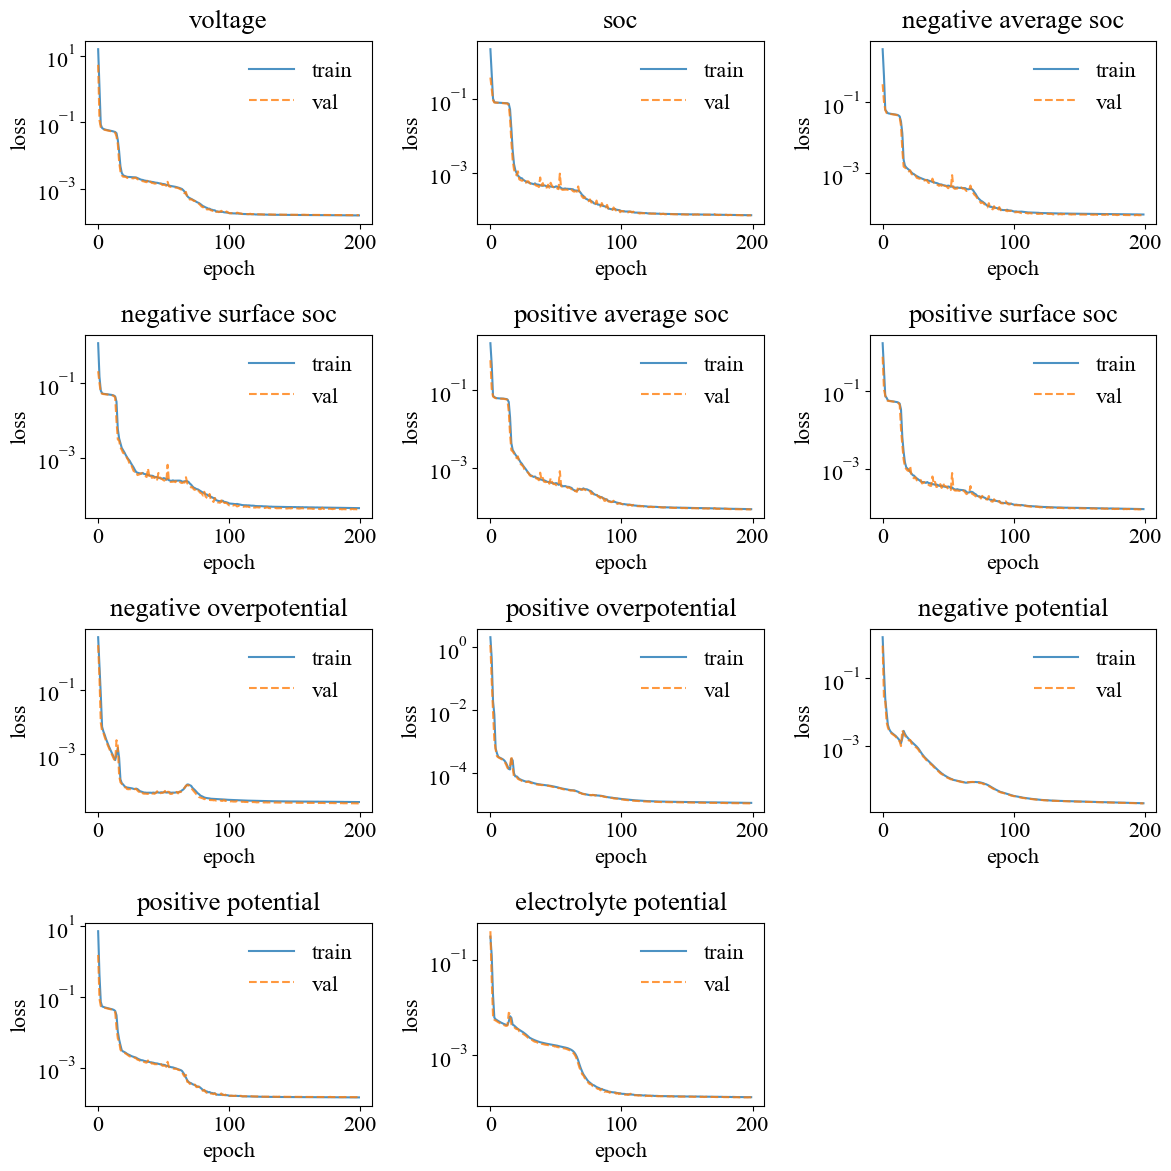

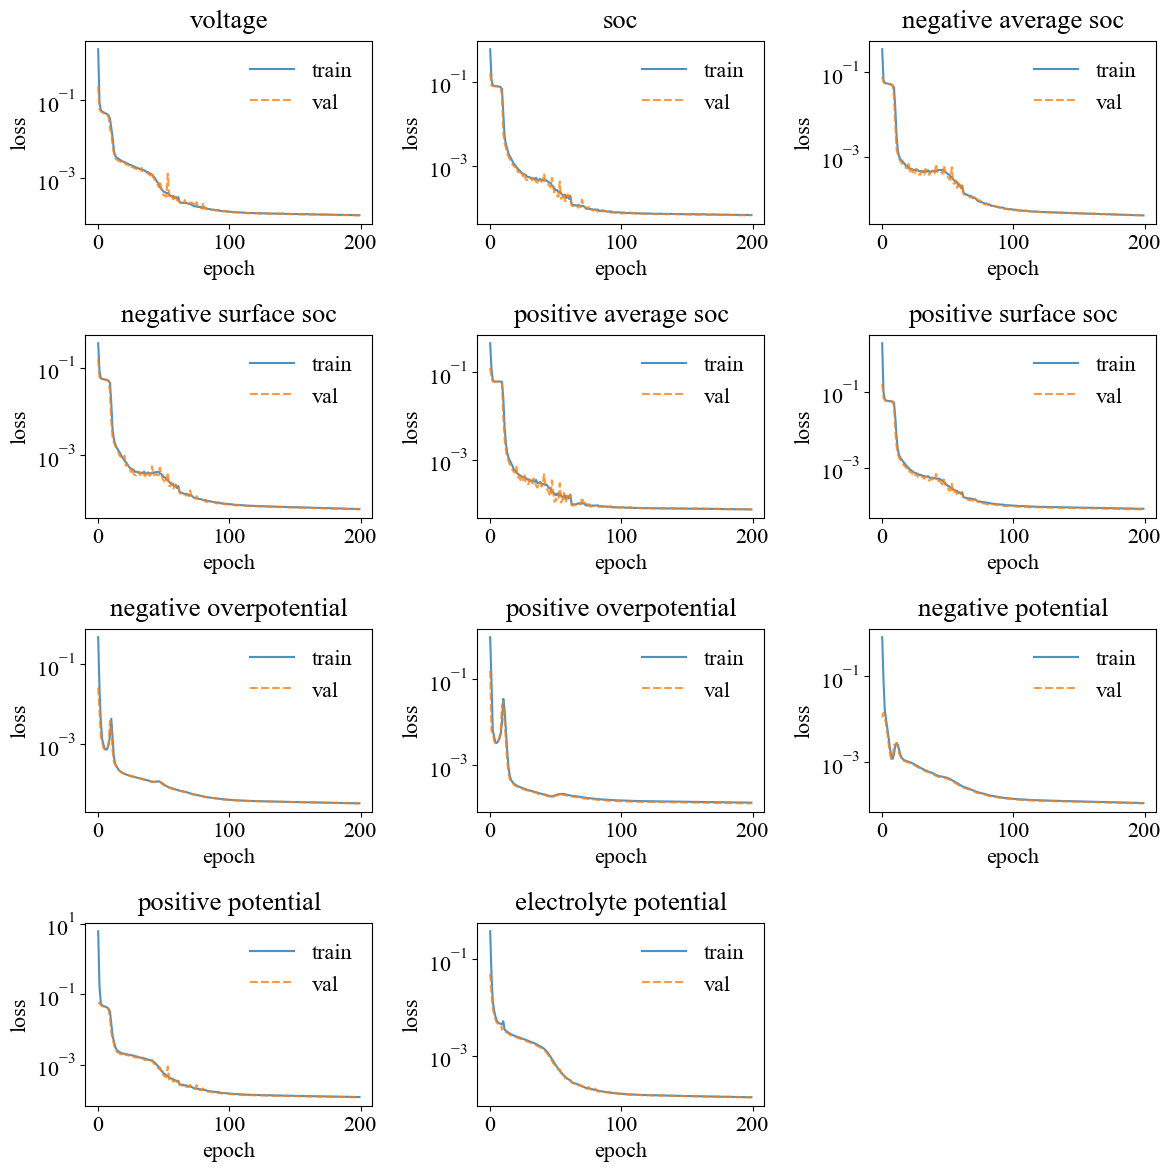

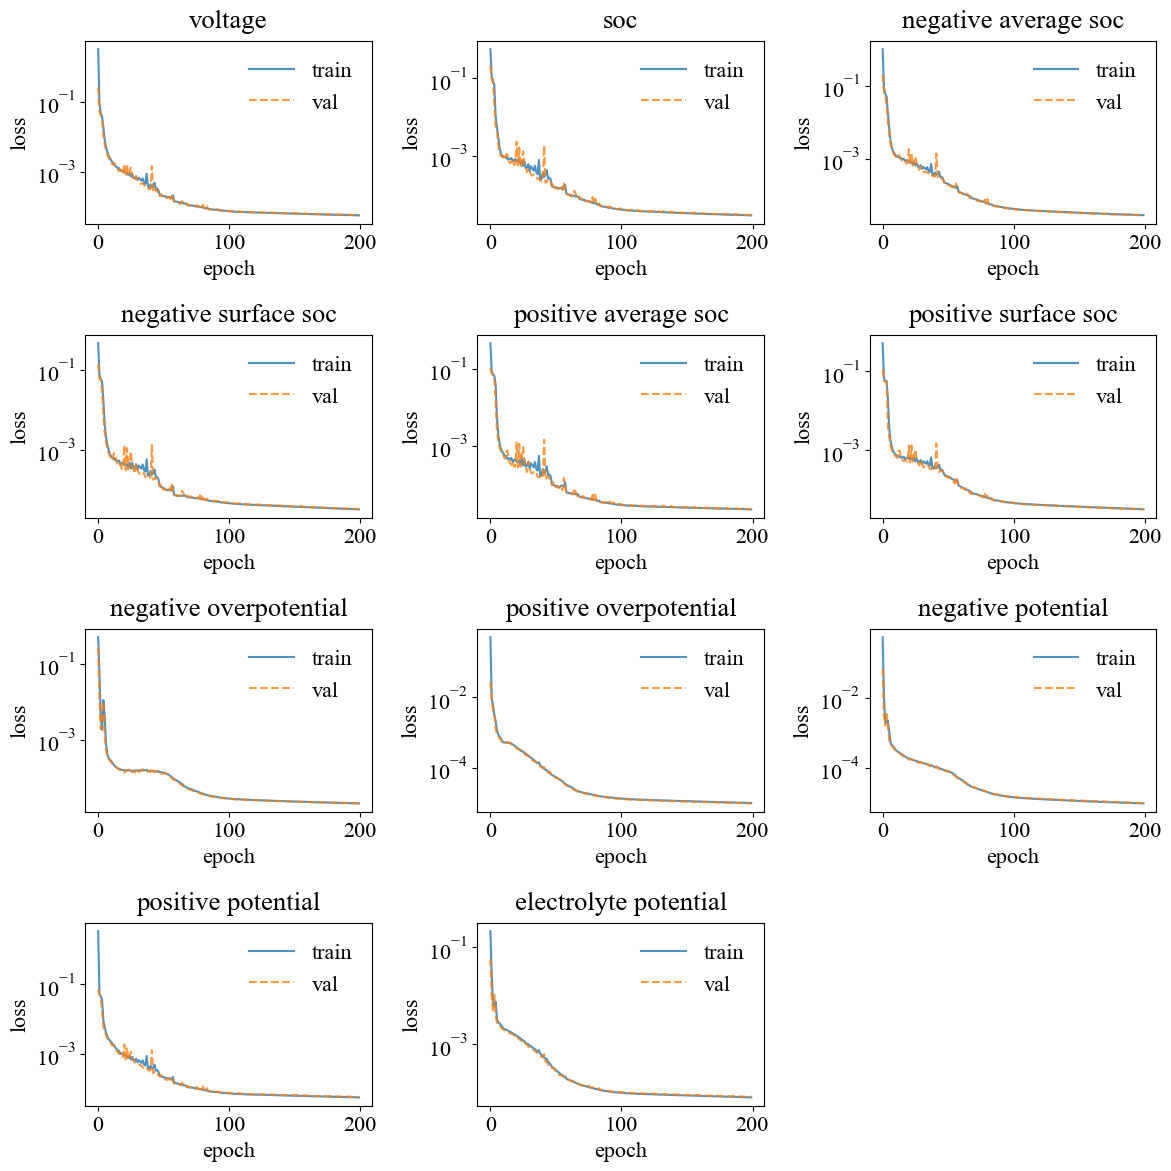

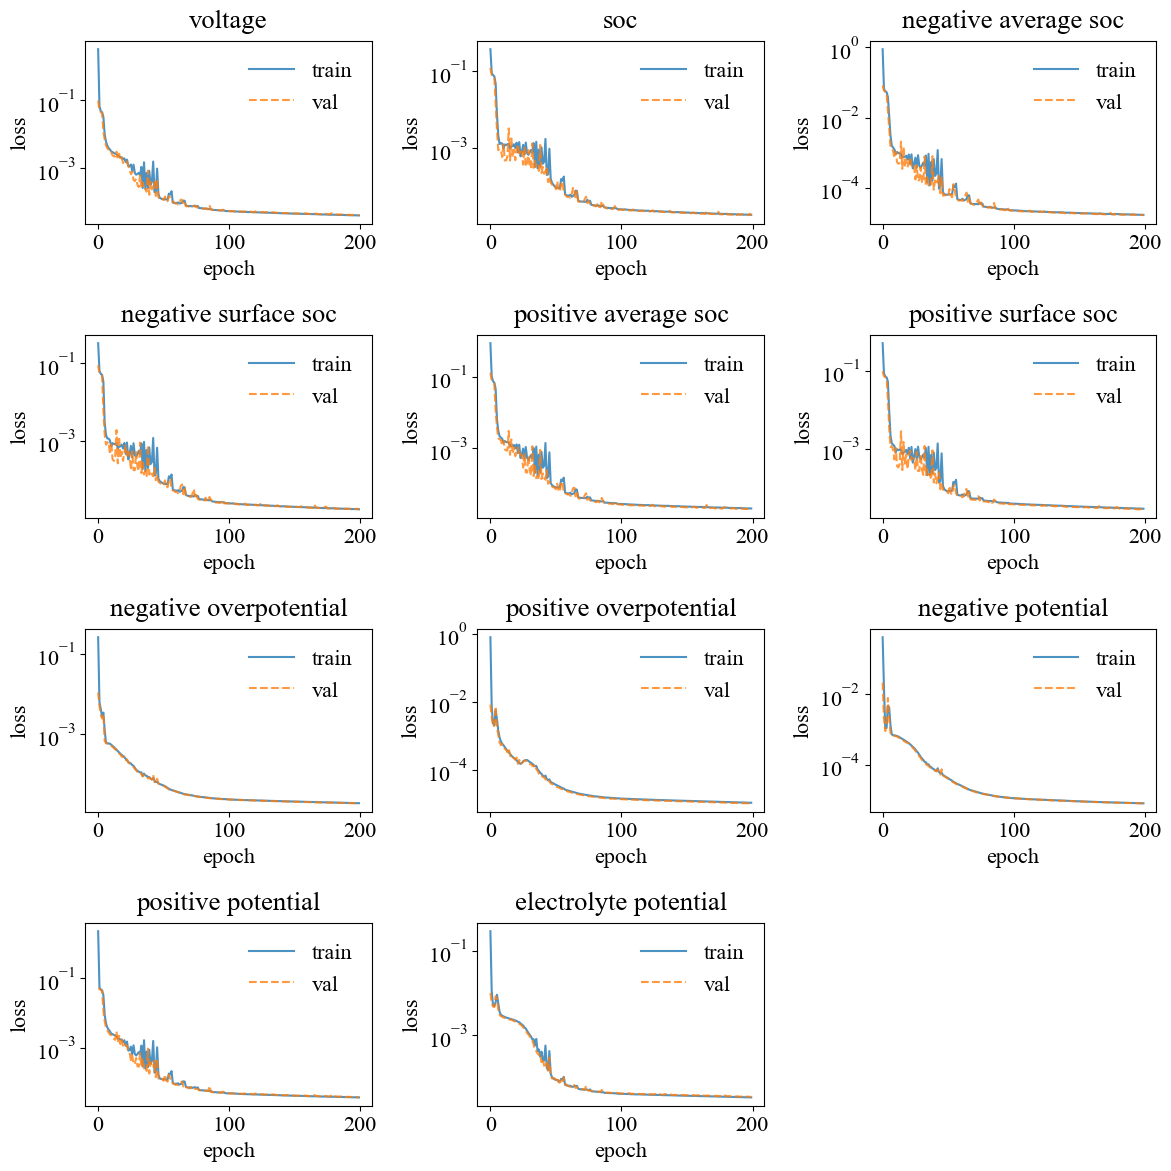

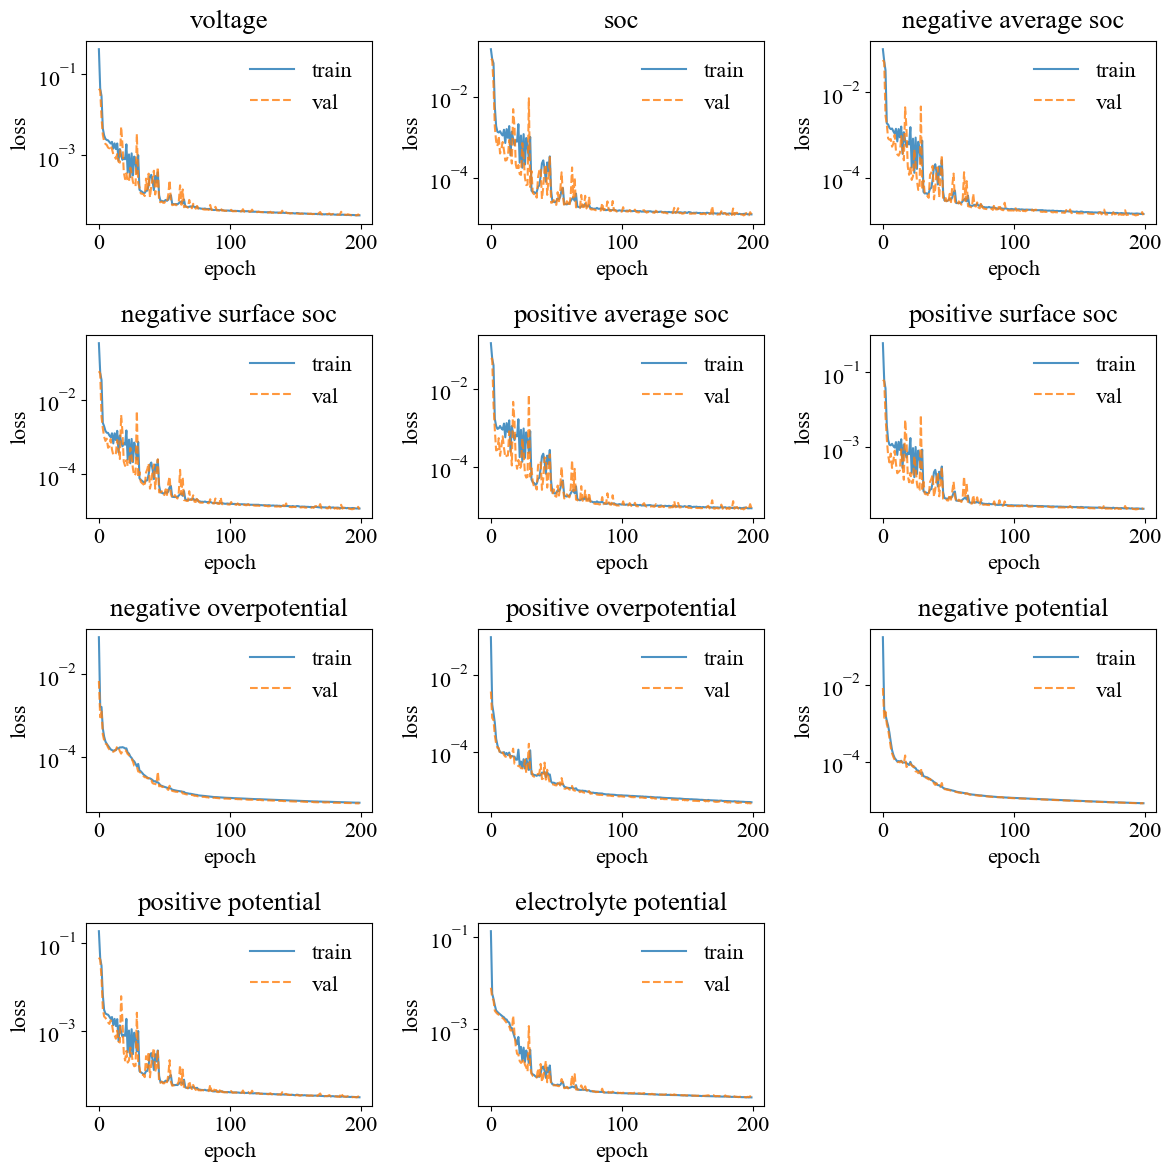

In [4]:
import logging, os
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 200
batch_size = 256

units_list = [4, 8, 16, 32, 64]
root_url = ""
repeat = 1
#learner_list = [SimpleCell,RK4Cell, KoopmanCell,GRUECTCell]
learner_list = [SingleCell,TwoLayerCell,GRUCell,RK4Cell,KoopmanCell]
learner_list = [RK4Cell]

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# # 定义动态学习率（例如指数衰减）
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10,      # 每多少步衰减一次
#     decay_rate=0.9          # 衰减系数
# )
n_outputs = dataset_train.shape[-1]-1
loss_weights= {f'output_{i+1}': 1/n_outputs for i in range(n_outputs)}
# loss_weights['output_1']= 1/3
# loss_weights['output_2']= 1/3

for units in units_list:
    for i in range(repeat):
        for learner in learner_list:
            with tf.device('/GPU:0'):
                name = f"{learner.__name__}_unit{units}_r{i}_int5-30"
                print(name)
                optimizer = bl.MultiTaskAdEMAMix(
                                  learning_rate=1e-3,
                                  beta_1=0.9,
                                  beta_2=0.999,
                                  task_config = {i: {"alpha": 0.5, "beta_3": 0.99} for i in range(dataset.shape[-1]-1)},
                                  task_regex=r'task_(\d+)_',  # 匹配task_0_, task_1_前缀
                                  epsilon=1e-7
                                ) 
                history = bl.training(dataset=dataset_train,
                                   units=units,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   validation_split=0.1,
                                   learner=learner,
                                   optimizer = optimizer,
                                   loss = 'mse',
                                   min_lr = 1e-5,
                                   #loss = bl.ConservativeLoss(lamda=0.1, name='conservative_loss'),
                                   #n_inv = 1,  # 输出数量+1个虚拟不变量
                                   root_url=root_url,
                                   name=name,
                                   mixed_pre = False,
                                   loss_weights = loss_weights
                                  )
                bl.plot_histroy(history=history,
                                n_outputs = dataset.shape[-1]-1,
                                root_url=root_url,
                                name=name,
                                columns = columns_all 
                               )

In [ ]:
columns = ['rate','voltage','soc']
columns_all = ['rate','voltage','soc',
            'negative average soc',
            'negative surface soc',
            'positive average soc',
            'positive surface soc',
            'negative overpotential',
            'positive overpotential',
            'negative potential',
            'positive potential',
            'electrolyte potential']

title = ['Voltage','Soc',
            'Negative average soc',
            'Negative surface soc',
            'Positive average soc',
            'Positive surface soc',
            'Negative overpotential',
            'Positive overpotential',
            'Negative potential',
            'Positive potential',
            'Electrolyte potential']
# root_url = "C:/Users/yjia0/my_model/battery_learner/test/"
file_name = "spme_dc_data0.6"

models = [SimpleCell,RNNCell,GRUCell,KoopmanCell,RK4Cell] #
            #0         1        2       3          4    
#model = models[4]
#model_name = model.__name__+"_unit8_r0_int2" #
models = [GRUCell] 

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#tf.debugging.set_log_device_placement(True)

for model in models:  
    model_name = model.__name__+"_unit8_r0_int5"
    with tf.device('/GPU:0'):
        print(model_name)
        bl.model_tester(
                    model = model,
                    model_name=model_name,
                    file_name=file_name,
                    columns= columns_all,
                    title=title,
                    lookback=3,
                    fix = [1],
    #                n_inv = 1,
                    split_params={'split': True, 'start': 1, 'num_predict':1000}
                    )

In [ ]:
def model_vaildation(
    model = None,
    model_name = None,
    data = None,
    columns = [],
    fix = [],
    lookback = 3,
    batch_size = 256,
    mean=None,
    variance=None
):
  
    n_outputs = data.shape[-1]-1
    
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.batch(batch_size=256)  # 自动分批次
    
#     mse = [tf.keras.metrics.MeanSquaredError(name=f'output_{i+1}') for i in range(n_outputs)]
#    mae = [tf.keras.metrics.MeanAbsoluteError(name=f'output_{i+1}') for i in range(n_outputs)]

    # 模型加载
    model = bl.load_tf_model(
        f"{model_name}",
        { model.__name__: model,
        'MultiTaskAdEMAMix': bl.MultiTaskAdEMAMix,
        'ConservativeLoss': bl.ConservativeLoss}
    )
    model.adapt(mean, variance)
    
    # 模型预测
    results = []
    for batch in dataset:  
        x_validation = batch
        y_validation = [batch[:,lookback:-1,i+1] for i in range(n_outputs)]     
        y_prediction = model(x_validation,fix = fix)
        
        error = np.array(y_validation)-np.array(y_prediction)
        error = error.reshape(n_outputs,-1)
        
        mae = np.mean(abs(error),axis=-1)
        std_dev = tf.math.reduce_std(error,axis=-1)
        standard_error = (std_dev / tf.sqrt(float(batch_size))).numpy()
        
        results.append([mae,standard_error])
            
    results = np.array(results)
#     print(results.shape)
    error_sum = np.mean(results,axis=0)
    for row in error_sum:
        print(' '.join(map(str, row))) 
            
#     for k in range(n_outputs):
#         print(f"output_{k+1}_MSE: {mse[k].result().numpy()}")
    
#     line = [error[k].result().numpy() for k in range(n_outputs)]
    
#     print(line)

#     # 预测结果保存
#     predictionfile = open(model_name+"+"+file_name+".csv","w", encoding='utf-8', newline='')
#     writer = csv.writer(predictionfile)  
#     n_outputs = len(predictions)
#     line = ['time']
#     line.extend(columns[1:])
#     writer.writerow(line)
#     for step in range(len(predictions[0][0])):          
#         line = [step]     
#         for k in range(n_outputs):          
#             line.append(float(predictions[k][0][step]))      
#         writer.writerow(line)   


In [ ]:
columns = ['rate','voltage','soc']
columns_all = ['rate','voltage','soc',
            'negative average soc',
            'negative surface soc',
            'positive average soc',
            'positive surface soc',
            'negative overpotential',
            'positive overpotential',
            'negative potential',
            'positive potential',
            'electrolyte potential']

models = [SimpleCell,RNNCell,GRUCell,KoopmanCell,RK4Cell]
            #0         1        2       3          4     
# model = models[4]
# models = [SimpleCell]

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#tf.debugging.set_log_device_placement(True)

for model in models:
    model_name = model.__name__+"_unit8_r0_int3"
    with tf.device('/GPU:0'):
#         print( model.__name__)
        model_vaildation(
                        model = model,
                        model_name=model_name,
                        data = dataset_test,
                        columns= columns_all,
                        lookback=3,
                        batch_size = 256,
                        mean=mean,
                        variance=var
                        )

In [ ]:
file_list_test = [
        "spme_cccv_data0.3",
        "spme_cccv_data1",
        "spme_dc_data0.4",
        "spme_dc_data0.6",
           ]

dataset_long = bl.preprocess(
                filelist = file_list_test,
                columns = columns_all,
                lookback = 1,                
                num_steps = 1000,
                max_samples = 1
)
print("验证集：",dataset_long.shape)

columns = ['rate','voltage','soc']
columns_all = ['rate','voltage','soc',
            'negative average soc',
            'negative surface soc',
            'positive average soc',
            'positive surface soc',
            'negative overpotential',
            'positive overpotential',
            'negative potential',
            'positive potential',
            'electrolyte potential']

models = [SimpleCell,RNNCell,GRUCell,KoopmanCell,RK4Cell]
            #0         1        2       3          4     
# model = models[4]


import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#tf.debugging.set_log_device_placement(True)

for model in models:
    model_name = model.__name__+"_unit8_r0_int3"
    with tf.device('/GPU:0'):
#         print( model.__name__)
        model_vaildation(
                        model = model,
                        model_name=model_name,
                        data = dataset_long,
                        columns= columns_all,
                        lookback=3,
                        batch_size = 1,
                        fix = [1],
                        mean=mean,
                        variance=var
                        )

In [ ]:
def model_speed_test(
    model = None,
    model_name = None,
    file_name='',
    columns=[],
    title=[],
    lookback = 3,
    batch_size = 2,
    seq_len = 100,
    repeat = 3,
    mean=None,
    variance=None
):    
    
    # 数据准备
    raw_data = bl.sample_reader(
        file_name=file_name,
        columns=columns,
        lookback=1
    )
     
    data = np.array(raw_data).reshape(len(raw_data), -1).astype(np.float32)
    data = data [:seq_len]
    
#    print(data.shape)
    n_outputs = data.shape[-1]-1
        
    data = tf.expand_dims(data, axis=0)  # shape变为 [1, :, :]
    
    if batch_size>1:
        data = tf.Variable(tf.tile(data, multiples=[batch_size, 1, 1]))  # shape变为 [3, :, :]
        for k in range(batch_size-1):
            data[k+1, lookback:, 0].assign(data[k, lookback:, 0]*1.1)
    
#     mse = [tf.keras.metrics.MeanSquaredError(name=f'output_{i+1}') for i in range(n_outputs)]
    mse = [tf.keras.metrics.MeanAbsoluteError(name=f'output_{i+1}') for i in range(n_outputs)]

    # 模型加载
    model = bl.load_tf_model(
        f"{model_name}",
        { model.__name__: model,
        'MultiTaskAdEMAMix': bl.MultiTaskAdEMAMix,
        'ConservativeLoss': bl.ConservativeLoss}
    )
    model.adapt(mean, variance)
    
    # 模型预测
    
    x_validation = data
    y_validation = [data[:,lookback:-1,i+1] for i in range(n_outputs)] 
#    print(x_validation.shape)
    cost = []
    for j in range(repeat):
        start = time.time()
        y_prediction = model(x_validation)
        end = time.time()
        cost.append((end - start)/100)
    
    cost = np.array(cost)
    mean = np.mean(cost)
    
    # 预测结果保存
    predictionfile = open(model_name+"+"+file_name+"+pal.csv","w", encoding='utf-8', newline='')
    writer = csv.writer(predictionfile)  

    for step in range(len(y_prediction[0][0])):          
        line = [step]     
        for k in range(batch_size):          
            line.append(float(y_prediction[0][k][step]))      
        writer.writerow(line)   
    
#    print(mean)
    return mean
    
#     for k in range(n_outputs):      
#         mse[k].update_state(y_validation[k], y_prediction[k]) 
#     line = [mse[k].result().numpy() for k in range(n_outputs)]
#     print(line)

In [ ]:
import time
import csv

columns = ['rate','voltage','soc']
columns_all = ['rate','voltage','soc',
            'negative average soc',
            'negative surface soc',
            'positive average soc',
            'positive surface soc',
            'negative overpotential',
            'positive overpotential',
            'negative potential',
            'positive potential',
            'electrolyte potential']
title = ['Voltage','Soc',
            'Negative average soc',
            'Negative surface soc',
            'Positive average soc',
            'Positive surface soc',
            'Negative overpotential',
            'Positive overpotential',
            'Negative potential',
            'Positive potential',
            'Electrolyte potential']

file_name = "spme_dc_data0.4"

models = [SimpleCell,RNNCell,GRUCell,KoopmanCell,RK4Cell]
            #0         1        2       3          4     
# model = models[4]
models = [SimpleCell]
batch_sizes = [1,1024,2048,4096,8192]
batch_sizes = [8]

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#tf.debugging.set_log_device_placement(True)

for model in models:
    model_name = model.__name__+"_unit8_r0_int2"
    print( model.__name__)
    repeat = 1
    time_cost = np.zeros((len(batch_sizes), repeat)) 
    with tf.device('/GPU:0'):  
        for j in range(repeat):     
            for k in range(len(batch_sizes)):
                time_cost[k,j] = model_speed_test(
                                model = model,
                                model_name=model_name,
                                file_name=file_name,
                                columns= columns_all,
                                title=title,
                                lookback=3,
                                batch_size = batch_sizes[k],
                                seq_len = 1000,
                                repeat = 1,
                                mean=mean,
                                variance=var
                                )
                print(time_cost)
    mean = np.mean(time_cost, axis=1)
    var = np.var(time_cost, axis=1, ddof=1) 
    
    for k in range(len(batch_sizes)):
        print(mean[k],var[k])
                  

In [ ]:
pip install statsmodels

In [ ]:
file_list_test = ["spme_cccv_data0.4",
           ]

dataset = bl.preprocess(
                filelist = file_list_test,
                columns = columns_all,
                lookback = 1,                
                num_steps = 3000,
                max_samples = 1
)

In [ ]:
import numpy as np
# 假设X为n维时间序列矩阵
rank = np.linalg.matrix_rank(dataset[0])
print("独立序列数量:", rank)
